# This notebook contains training step and analysis using nmae result...

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, GenericUnivariateSelect
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold

import xgboost as xgb

In [2]:
# Normalized Mean Absolute Error
def nmae(y_pred, y_test):
    mae = mean_absolute_error(y_test, y_pred)
    # mape = np.abs(y_test_idx - y_pred_idx) / y_test_idx
    mean_true = np.mean(np.abs(y_test))
    return (mae / mean_true)

def normalized_mean_absolute_error(y_true, y_pred):
    """
    Calculates the Normalized Mean Absolute Error (NMAE).

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Estimated target values.

    Returns:
        float: The Normalized Mean Absolute Error.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length.")

    mae = np.mean(np.abs(y_true - y_pred))

    # Calculate the range of actual values
    y_range = np.max(y_true) - np.min(y_true)

    # Avoid division by zero if the range is zero
    if y_range == 0:
        return 0.0 if mae == 0 else np.inf
    else:
        nmae = mae / y_range
        return nmae

def print_scores(scores, name="NMAE"):
    """
    Prints cross-validation scores returned by cross_val_score.
    Since error scorers in sklearn are usually negative (greater_is_better=False),
    this function converts them to positive percentages.
    """
    scores_pct = -scores * 100  # convert to positive percentage

    print(f"{name} per fold:")
    for i, s in enumerate(scores_pct):
        print(f"  Fold {i+1}: {s:.2f}%")

    print(f"\nMean {name}: {np.mean(scores_pct):.2f}%")

In [3]:
# Load write dataset t100
x_t100 = pd.read_csv('datasets/exp90c_11h/t100/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t100.shape)
x_t100 = x_t100.iloc[3600:]
print(x_t100.shape)
x_t100.head(5)

(40203, 1814)
(36603, 1814)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_blkio_device_usage_total_4,container_blkio_device_usage_total_5,container_blkio_device_usage_total_6,container_blkio_device_usage_total_7,container_blkio_device_usage_total_8,...,network_transmit_bytes_per_container_30,network_transmit_bytes_per_container_31,network_transmit_bytes_per_container_32,network_transmit_bytes_per_container_33,network_transmit_bytes_per_container_34,network_transmit_bytes_per_container_35,network_transmit_bytes_per_container_36,network_transmit_bytes_per_container_37,network_transmit_bytes_per_container_38,network_transmit_bytes_per_container_39
3600,1764344128,8192,1293385728,8192,1202991104,15355904,1325654016,15355904,1214967808,0,...,34400.745841,0,11421.387458,0,43264.130435,0,12733.977620,0,0.0,9.026435
3601,1764344129,8192,1293385728,8192,1202991104,15355904,1325654016,15355904,1214967808,0,...,34400.745841,0,9607.999027,0,38533.483580,0,8718.030490,0,0.0,12.612613
3602,1764344130,8192,1293385728,8192,1202991104,15355904,1325654016,15355904,1214967808,0,...,46528.076811,0,12270.752270,0,38533.483580,0,12057.424315,0,0.0,11.894647
3603,1764344131,8192,1293385728,8192,1202991104,15355904,1326444544,15355904,1214967808,0,...,47872.531418,0,13694.648193,0,33625.596408,0,12449.702184,0,0.0,11.894647
3604,1764344132,8192,1293385728,8192,1202991104,15355904,1326444544,15355904,1214967808,0,...,45807.725322,0,13694.648193,0,37798.799747,0,11698.107353,0,0.0,0.000000


In [4]:
# Load y t100
y_t100 = pd.read_csv('datasets/exp90c_11h/t100/20251128_143528564_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t100.shape)
y_t100 = y_t100.iloc[3600:]
print(y_t100.shape)
y_t100.head(5)

(40203, 1815)
(36603, 1815)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_blkio_device_usage_total_4,container_blkio_device_usage_total_5,container_blkio_device_usage_total_6,container_blkio_device_usage_total_7,container_blkio_device_usage_total_8,...,network_transmit_bytes_per_container_31,network_transmit_bytes_per_container_32,network_transmit_bytes_per_container_33,network_transmit_bytes_per_container_34,network_transmit_bytes_per_container_35,network_transmit_bytes_per_container_36,network_transmit_bytes_per_container_37,network_transmit_bytes_per_container_38,network_transmit_bytes_per_container_39,w_99th_percentile
3600,1764344128,8192,1293385728,8192,1202991104,15355904,1325654016,15355904,1214967808,0,...,0,11421.387458,0,43264.130435,0,12733.977620,0,0.0,9.026435,4.000000
3601,1764344129,8192,1293385728,8192,1202991104,15355904,1325654016,15355904,1214967808,0,...,0,9607.999027,0,38533.483580,0,8718.030490,0,0.0,12.612613,4.000000
3602,1764344130,8192,1293385728,8192,1202991104,15355904,1325654016,15355904,1214967808,0,...,0,12270.752270,0,38533.483580,0,12057.424315,0,0.0,11.894647,4.000000
3603,1764344131,8192,1293385728,8192,1202991104,15355904,1326444544,15355904,1214967808,0,...,0,13694.648193,0,33625.596408,0,12449.702184,0,0.0,11.894647,4.663333
3604,1764344132,8192,1293385728,8192,1202991104,15355904,1326444544,15355904,1214967808,0,...,0,13694.648193,0,37798.799747,0,11698.107353,0,0.0,0.000000,18.930000


In [5]:
# Load y t100
y_t100_r = pd.read_csv('datasets/exp90c_11h/t100/20251128_143528564_r.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t100_r.shape)
y_t100_r = y_t100_r.iloc[3600:]
print(y_t100_r.shape)
y_t100_r.head(5)

(40203, 45)
(36603, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
3600,1764344128,9000,0,0,0,5,1,2.438981,2.495836,2.499151,...,3,17,4.270000,1.498193,4.0,5.0,6.0,7.00,9.326667,17
3601,1764344129,9002,0,0,0,5,1,2.438862,2.504164,2.500818,...,3,17,4.296667,1.617832,4.0,5.0,6.0,7.66,12.653333,17
3602,1764344130,9005,0,0,0,5,1,2.439014,2.504164,2.500818,...,3,17,4.270000,1.612172,4.0,5.0,6.0,7.66,12.653333,17
3603,1764344131,9007,0,0,0,5,1,2.438895,2.504164,2.500818,...,3,17,4.250000,1.609181,4.0,5.0,6.0,7.66,12.653333,17
3604,1764344132,9010,0,0,0,5,1,2.439047,2.504164,2.500818,...,3,17,4.230000,1.603852,4.0,4.0,6.0,7.66,12.653333,17


In [6]:
# Load write dataset t300
x_t300 = pd.read_csv('datasets/exp90c_11h/t300/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t300.shape)
x_t300 = x_t300.iloc[3600:]
print(x_t300.shape)
x_t300.head(5)

(40203, 1814)
(36603, 1814)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_blkio_device_usage_total_4,container_blkio_device_usage_total_5,container_blkio_device_usage_total_6,container_blkio_device_usage_total_7,container_blkio_device_usage_total_8,...,network_transmit_bytes_per_container_30,network_transmit_bytes_per_container_31,network_transmit_bytes_per_container_32,network_transmit_bytes_per_container_33,network_transmit_bytes_per_container_34,network_transmit_bytes_per_container_35,network_transmit_bytes_per_container_36,network_transmit_bytes_per_container_37,network_transmit_bytes_per_container_38,network_transmit_bytes_per_container_39
3600,1764502621,8192,68127555584,8192,56090824704,1504612352,34271240192,1504612352,27599638528,0,...,37648.513302,0,12424.115914,0,43554.298150,0,15591.553637,0,0.000000,0.0
3601,1764502622,8192,68127555584,8192,56090824704,1504612352,34271240192,1504612352,27599638528,0,...,46417.486972,0,7592.400000,0,44236.095764,0,15099.641577,0,0.000000,0.0
3602,1764502623,8192,68127555584,8192,56090824704,1504612352,34271240192,1504612352,27599638528,0,...,44674.543023,0,12116.323600,0,43873.850197,0,12067.494429,0,0.000000,0.0
3603,1764502624,8192,68127555584,8192,56090824704,1504612352,34271240192,1504612352,27599638528,0,...,39860.457408,0,14978.693182,0,38120.202981,0,12955.641026,0,0.000000,0.0
3604,1764502625,8192,68127555584,8192,56090824704,1504612352,34271240192,1504612352,27599638528,0,...,30885.643372,0,16055.502696,0,38852.114950,0,9667.610828,0,107.579462,0.0


In [7]:
# Load y t300
y_t300 = pd.read_csv('datasets/exp90c_11h/t300/20251130_103701313_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t300.shape)
y_t300 = y_t300.iloc[3600:]
print(y_t300.shape)
y_t300.head(5)

(40203, 45)
(36603, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
3600,1764502621,27000,0,0,0,4,4,7.199910,7.504164,7.500461,...,2,32,2.930000,1.730631,3.0,3.0,3.0,3.0,4.0,32
3601,1764502622,27008,0,0,0,4,4,7.200389,7.495836,7.498800,...,2,32,2.930000,1.730631,3.0,3.0,3.0,3.0,4.0,32
3602,1764502623,27015,0,0,0,4,4,7.200071,7.495836,7.498800,...,2,32,2.926667,1.731459,3.0,3.0,3.0,3.0,4.0,32
3603,1764502624,27024,0,0,0,4,4,7.200549,7.495836,7.498800,...,2,32,2.936667,1.730889,3.0,3.0,3.0,3.0,4.0,32
3604,1764502625,27030,0,0,0,4,4,7.200231,7.495836,7.498800,...,2,32,2.943333,1.729187,3.0,3.0,3.0,3.0,4.0,32


In [8]:
# Load write dataset t500
x_t500 = pd.read_csv('datasets/exp90c_11h/t500/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t500.shape)
x_t500 = x_t500.iloc[3600:]
print(x_t500.shape)
x_t500.head(5)

(40203, 1814)
(36603, 1814)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_blkio_device_usage_total_4,container_blkio_device_usage_total_5,container_blkio_device_usage_total_6,container_blkio_device_usage_total_7,container_blkio_device_usage_total_8,...,network_transmit_bytes_per_container_30,network_transmit_bytes_per_container_31,network_transmit_bytes_per_container_32,network_transmit_bytes_per_container_33,network_transmit_bytes_per_container_34,network_transmit_bytes_per_container_35,network_transmit_bytes_per_container_36,network_transmit_bytes_per_container_37,network_transmit_bytes_per_container_38,network_transmit_bytes_per_container_39
3600,1764553267,53248,117077155840,53248,96565288960,1504624640,83104567296,1504624640,68184735744,0,...,31162.099276,0,11174.955986,0,39642.081001,0,15040.949555,0,0.0,0.0
3601,1764553268,53248,117077155840,53248,96565288960,1504624640,83104567296,1504624640,68184735744,0,...,23662.643942,0,11059.015679,0,39642.081001,0,15040.949555,0,0.0,0.0
3602,1764553269,53248,117077155840,53248,96565288960,1504624640,83104567296,1504624640,68184735744,0,...,38044.865719,0,8968.562345,0,47212.228101,0,10174.029451,0,0.0,0.0
3603,1764553270,53248,117077155840,53248,96565288960,1504624640,83104567296,1504624640,68184735744,0,...,51126.154826,0,11665.152572,0,47212.228101,0,6795.064378,0,0.0,0.0
3604,1764553271,53248,117077155840,53248,96565288960,1504624640,83104567296,1504624640,68184735744,0,...,42809.005548,0,14490.294588,0,31734.527258,0,10669.191919,0,0.0,0.0


In [9]:
# Load y t500
y_t500 = pd.read_csv('datasets/exp90c_11h/t500/20251201_004107569_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t500.shape)
y_t500 = y_t500.iloc[3600:]
print(y_t500.shape)
y_t500.head(5)

(40203, 45)
(36603, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
3600,1764553267,27000,0,0,0,8,2,7.199893,7.504164,7.500461,...,2,8,3.186667,0.599740,3.0,3.0,4.0,5.0,6.663333,8
3601,1764553268,27008,0,0,0,8,2,7.200107,7.495836,7.498800,...,2,8,3.183333,0.597981,3.0,3.0,4.0,5.0,6.663333,8
3602,1764553269,27016,0,0,0,8,2,7.200319,7.495836,7.498800,...,2,8,3.183333,0.597981,3.0,3.0,4.0,5.0,6.663333,8
3603,1764553270,27023,0,0,0,8,2,7.200533,7.495836,7.498800,...,2,8,3.186667,0.599740,3.0,3.0,4.0,5.0,6.663333,8
3604,1764553271,27030,0,0,0,8,2,7.200479,7.495836,7.498800,...,2,8,3.183333,0.597981,3.0,3.0,4.0,5.0,6.663333,8


In [10]:
# Target values
print(f"T100 - Min: {np.min(y_t100["w_99th_percentile"].to_numpy())} | Max: {np.max(y_t100["w_99th_percentile"].to_numpy())} | Mean: {np.mean(y_t100["w_99th_percentile"].to_numpy())}")

print(f"T300 - Min: {np.min(y_t300["w_99th_percentile"].to_numpy())} | Max: {np.max(y_t300["w_99th_percentile"].to_numpy())} | Mean: {np.mean(y_t300["w_99th_percentile"].to_numpy())}")

print(f"T500 - Min: {np.min(y_t500["w_99th_percentile"].to_numpy())} | Max: {np.max(y_t500["w_99th_percentile"].to_numpy())} | Mean: {np.mean(y_t500["w_99th_percentile"].to_numpy())}")

T100 - Min: 2.0 | Max: 114.296666666666 | Mean: 12.101019679625342
T300 - Min: 3.0 | Max: 213.643333333333 | Mean: 49.46558114544309
T500 - Min: 3.6633333333333 | Max: 420.653333333333 | Mean: 87.56789926144444


# KDE for write dataset metrics

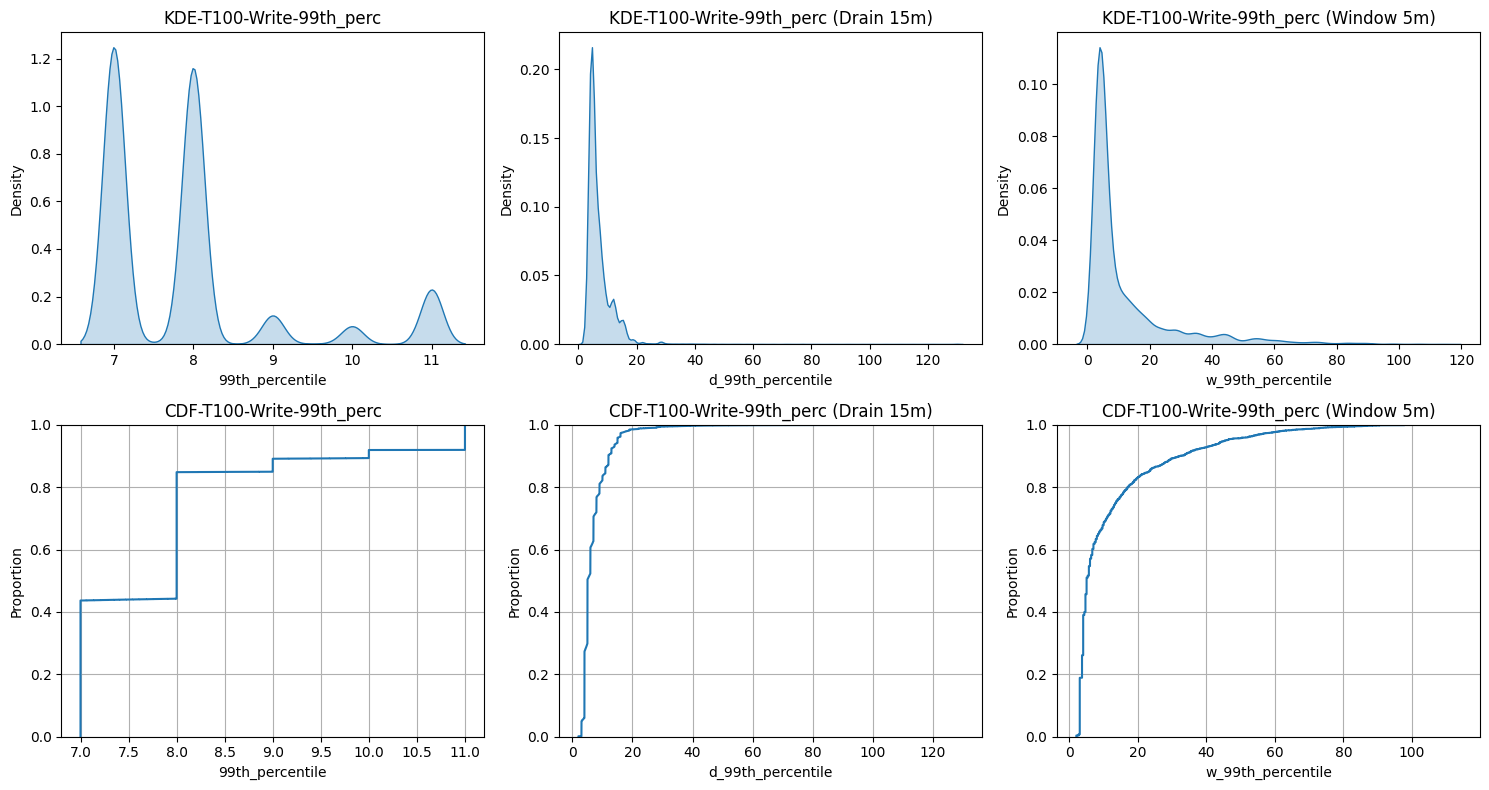

In [10]:
# 99th_percentile t100
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t100['99th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T100-Write-99th_perc")

sns.kdeplot(y_t100['d_99th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T100-Write-99th_perc (Drain 15m)")

sns.kdeplot(y_t100['w_99th_percentile'],fill=True, ax=axes[0,2])
axes[0,2].set_title("KDE-T100-Write-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t100, x='99th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T100-Write-99th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t100, x='d_99th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T100-Write-99th_perc (Drain 15m)")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t100, x='w_99th_percentile', ax=axes[1,2])
axes[1,2].set_title("CDF-T100-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

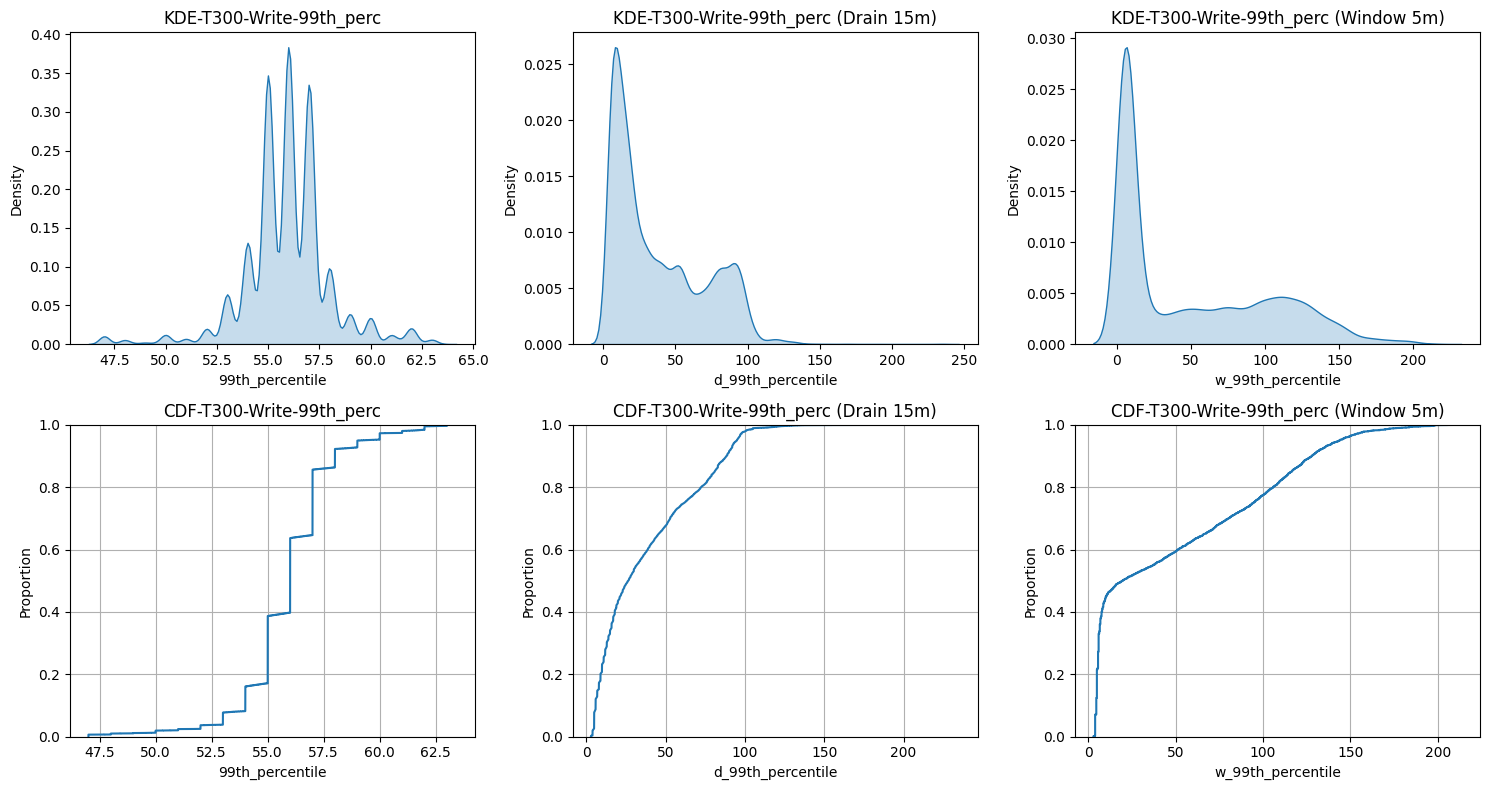

In [11]:
# 99th_percentile t300
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t300['99th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T300-Write-99th_perc")

sns.kdeplot(y_t300['d_99th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T300-Write-99th_perc (Drain 15m)")

sns.kdeplot(y_t300['w_99th_percentile'],fill=True, ax=axes[0,2])
axes[0,2].set_title("KDE-T300-Write-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t300, x='99th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T300-Write-99th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t300, x='d_99th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T300-Write-99th_perc (Drain 15m)")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t300, x='w_99th_percentile', ax=axes[1,2])
axes[1,2].set_title("CDF-T300-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

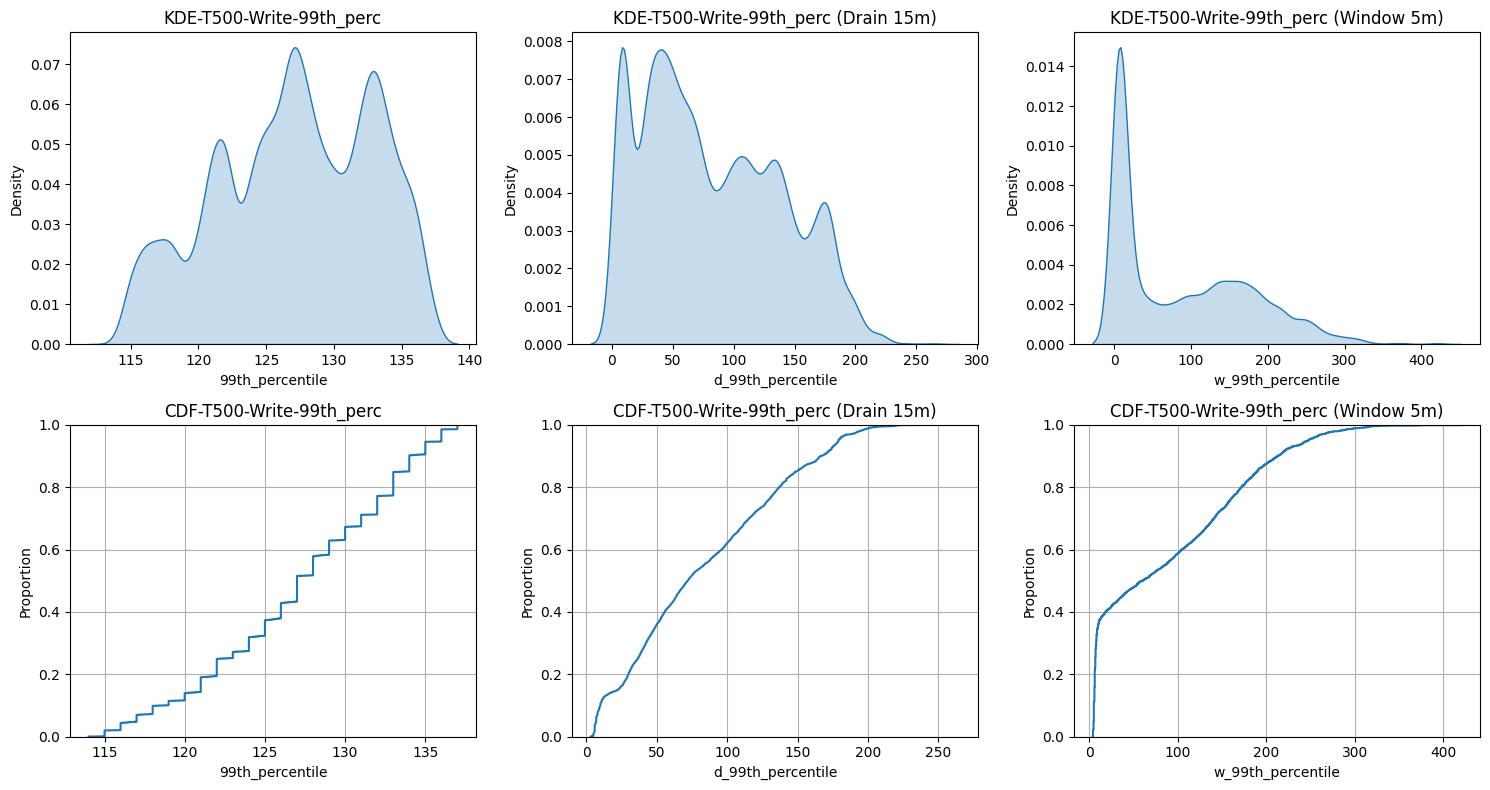

In [12]:
# 99th_percentile t500
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t500['99th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T500-Write-99th_perc")

sns.kdeplot(y_t500['d_99th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T500-Write-99th_perc (Drain 15m)")

sns.kdeplot(y_t500['w_99th_percentile'],fill=True, ax=axes[0,2])
axes[0,2].set_title("KDE-T500-Write-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t500, x='99th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T500-Write-99th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t500, x='d_99th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T500-Write-99th_perc (Drain 15m)")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t500, x='w_99th_percentile', ax=axes[1,2])
axes[1,2].set_title("CDF-T500-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [6]:
def get_select_k_best_ds(x, y, k):
    selector = SelectKBest(f_regression, k=k)
    k_best_ds = selector.fit_transform(x, y)

    # Get a boolean mask of selected features
    selected_features_mask = selector.get_support()

    # Get the names of the selected features
    selected_feature_names = x.columns[selected_features_mask]
    print(selected_feature_names)

    k_best_ds = pd.DataFrame(k_best_ds, columns=selected_feature_names, index=x.index)
    print(k_best_ds.shape)
    k_best_ds.head(5)
    return k_best_ds

# Random Forest training using all features and k best features...

## train 70%, test 30%

In [10]:
def kfold_train_and_generate_plots(X, y, y_col, kfold, title, image_path):
    random_forest_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
    
    # Set up K-fold cross-validation
    kf = KFold(n_splits=kfold, shuffle=True, random_state=42) # 5

    scores = []
    fig, axes = plt.subplots(kfold, 2, figsize=(15, 20))
    time = datetime.datetime.now(tz=datetime.timezone.utc)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Create splits
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx][y_col], y.iloc[test_idx][y_col]
    
        sns.ecdfplot(data=y, x=y_col, label='y', ax=axes[fold,0])
        sns.ecdfplot(x=y_train, label=f'y_train_{fold}', ax=axes[fold,0])
        sns.ecdfplot(x=y_test, label=f'y_test_{fold}', ax=axes[fold,0])
        axes[fold,0].set_title(f"CDF-{title}-F{fold}")
        axes[fold,0].grid(True)
        axes[fold,0].legend()
    
        sns.kdeplot(y[y_col],fill=True, label='y', ax=axes[fold,1])
        sns.kdeplot(y_train,fill=True, label=f'y_train_{fold}', ax=axes[fold,1])
        sns.kdeplot(y_test,fill=True, label=f'y_test_{fold}', ax=axes[fold,1])
        axes[fold,1].set_title(f"KDE-{title}-F{fold}")
        axes[fold,1].legend()
    
        # Train model
        random_forest_model.fit(X_train, y_train)
    
        # Predict
        y_pred = random_forest_model.predict(X_test)
    
        # Compute NMAE
        nmae_value = nmae(y_pred, y_test)
    
        scores.append(nmae_value)
    
    print(f'T100 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')
    
    for i, s in enumerate(scores):
        print(f"Fold {i+1}: {s:.2%}")
    
    print(f"Mean NMAE: {np.mean(scores):.2%}\n")

    plt.tight_layout()
    plt.show()

    fig.savefig(f'{image_path}/{title}.png', dpi=fig.dpi, format='png')

## T100

T100 - Rand. Forest Training time: 244.751513s
Fold 1: 0.06%
Fold 2: 0.04%
Fold 3: 0.05%
Mean NMAE: 0.05%



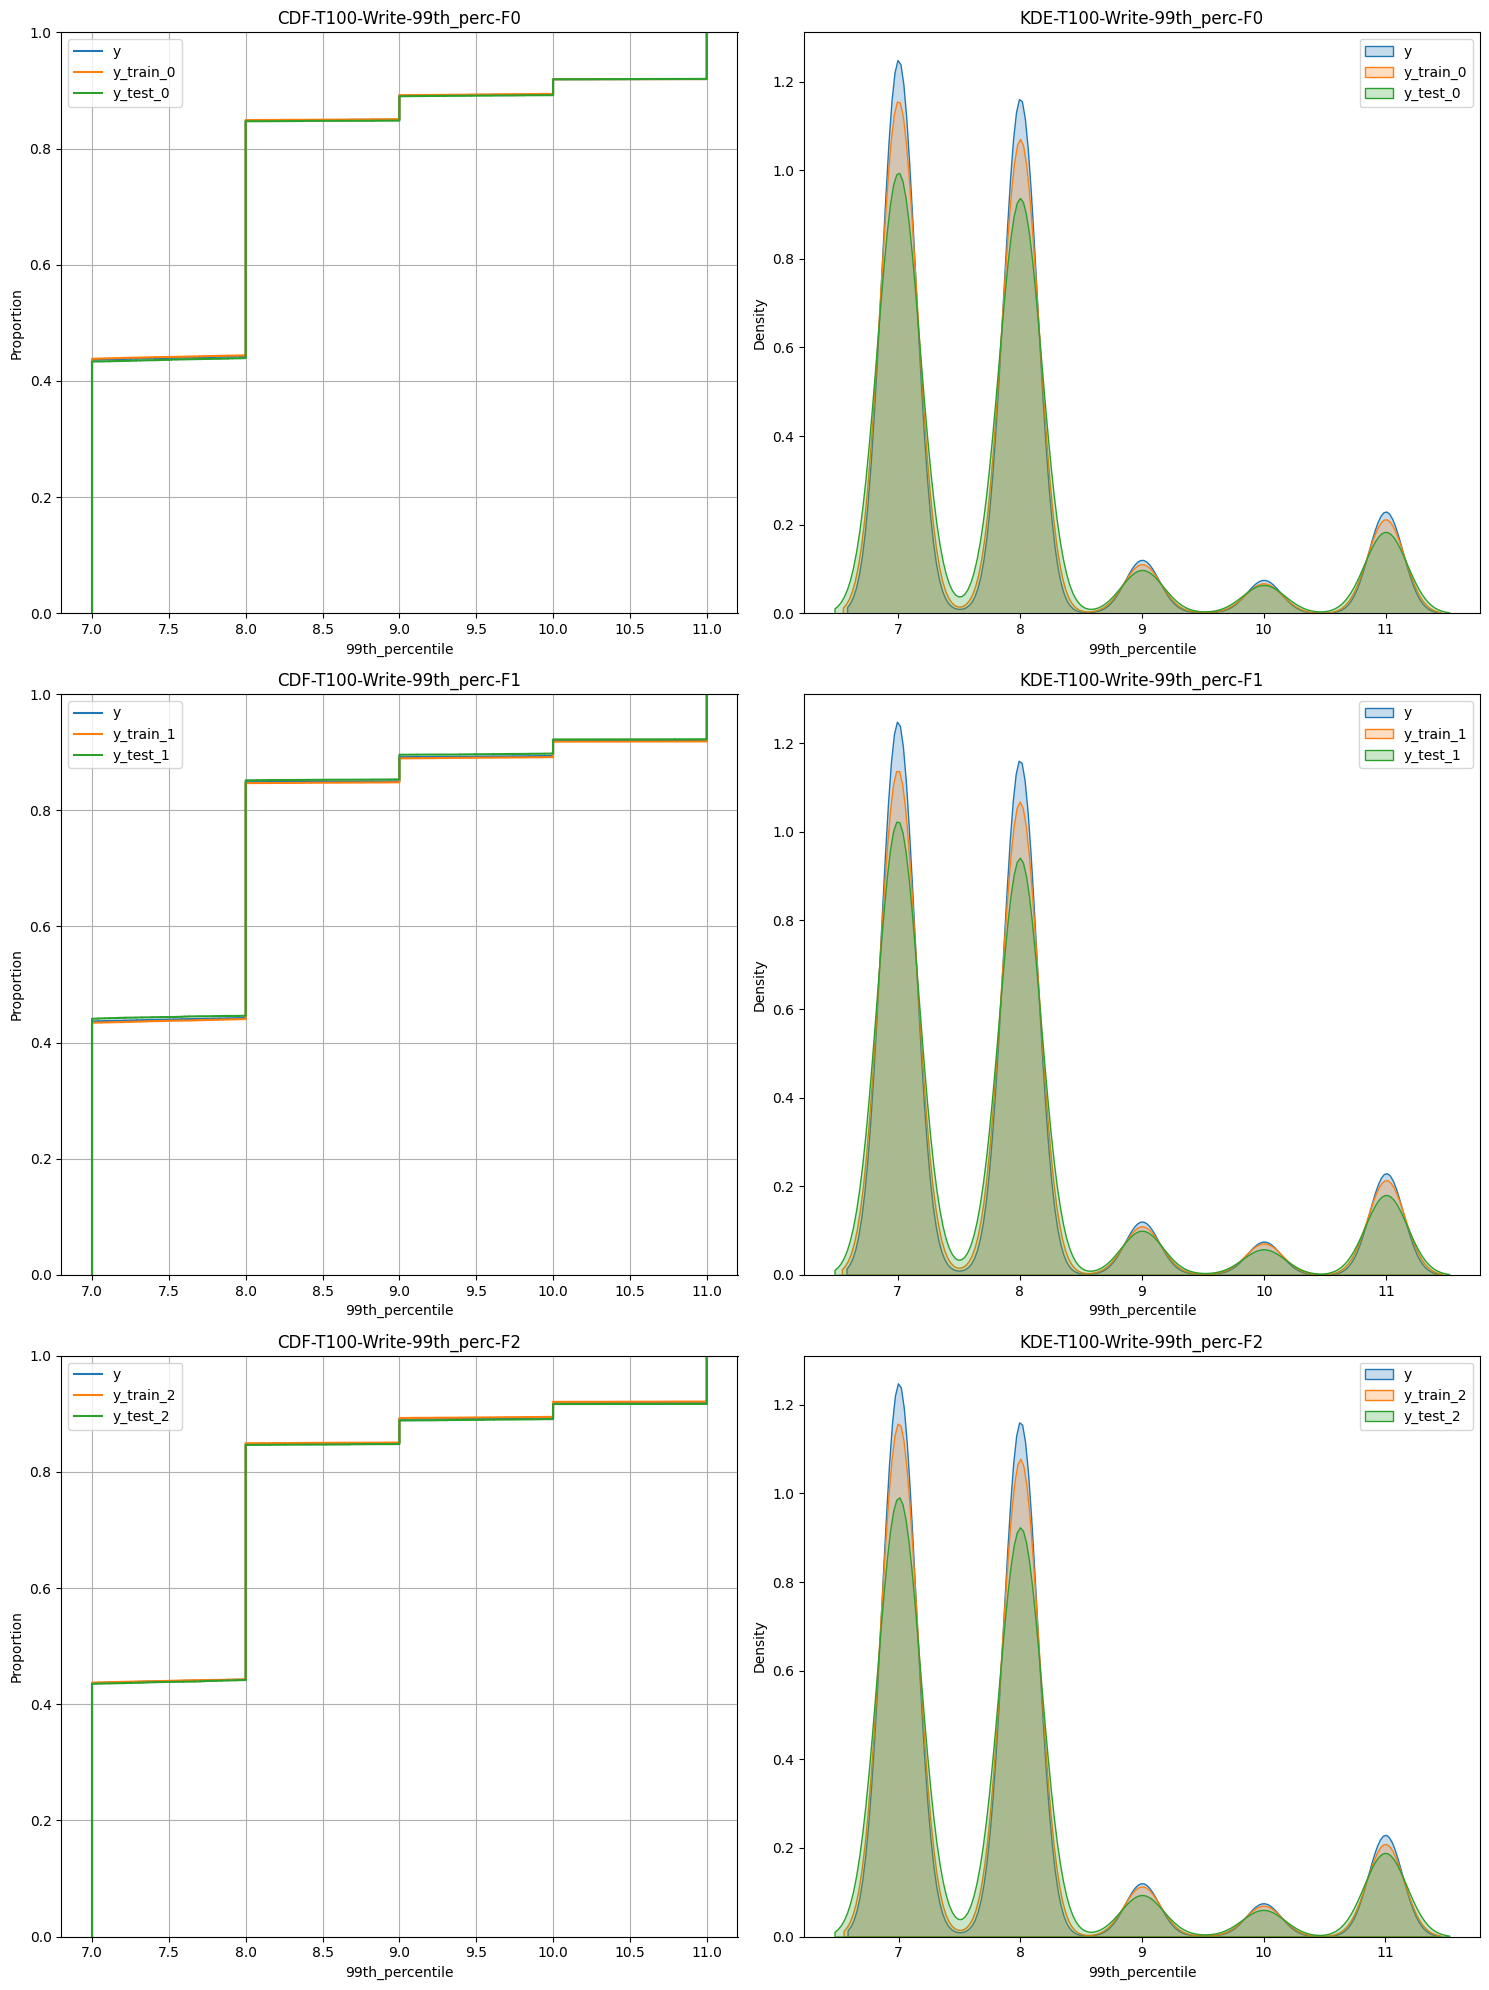

In [15]:
# Full dataset - wihout normalization...
kfold_train_and_generate_plots(x_t100, y_t100, "99th_percentile", 3, "T100-Write-99th_perc", "images/exp_90c_11h")

T100 - Rand. Forest Training time: 587.724952s
Fold 1: 3.75%
Fold 2: 3.72%
Fold 3: 4.56%
Mean NMAE: 4.01%



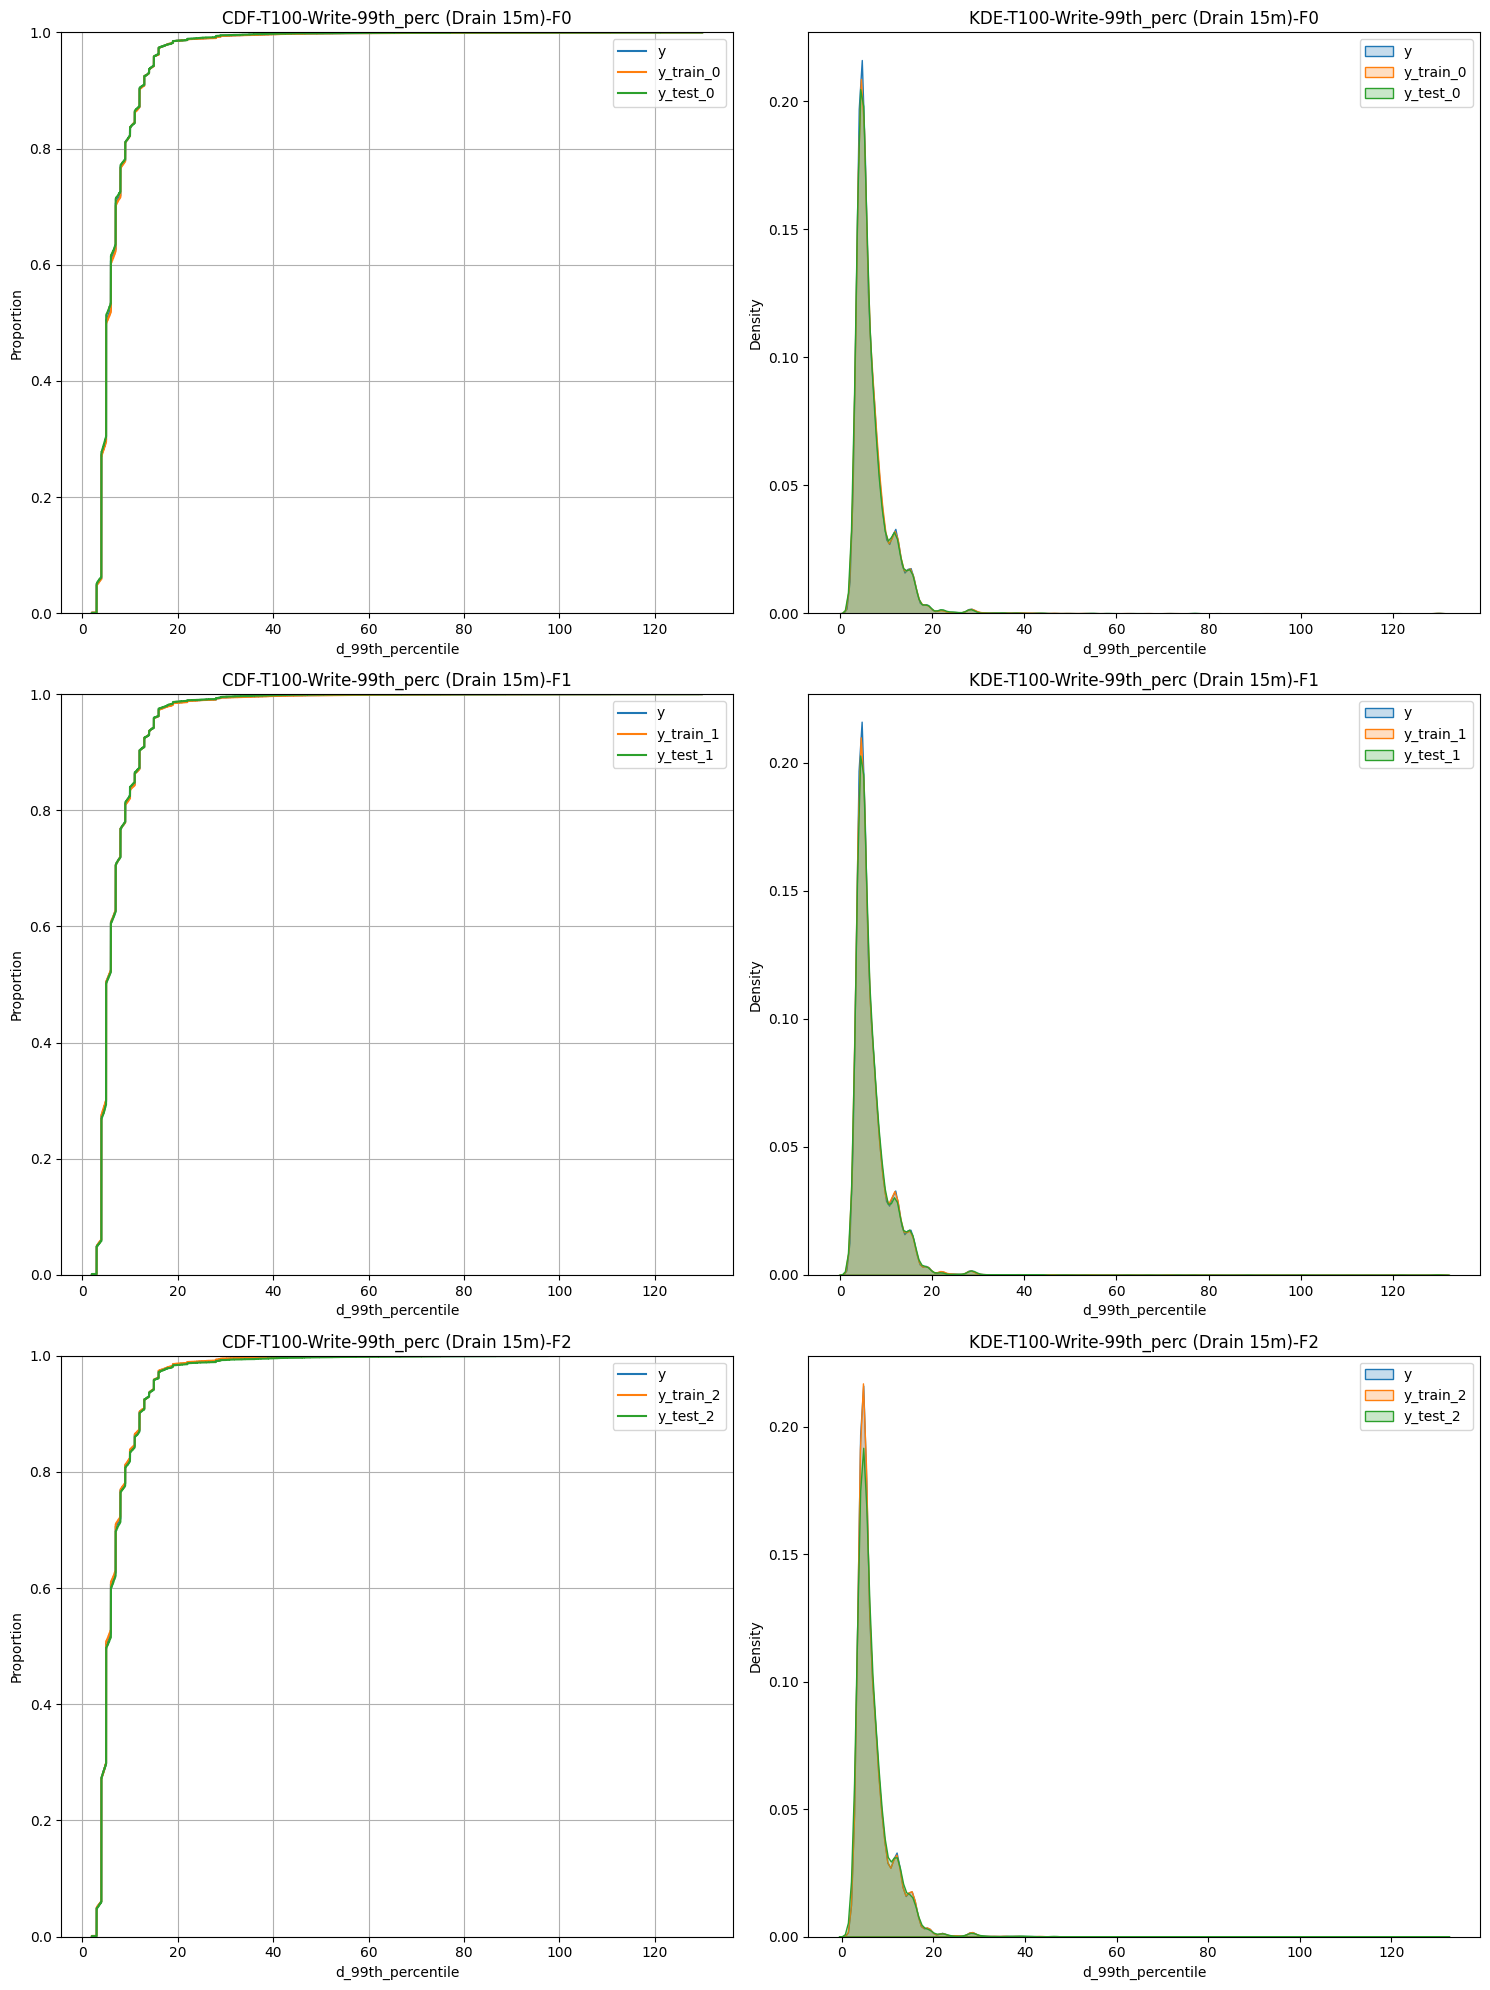

In [17]:
kfold_train_and_generate_plots(x_t100, y_t100, "d_99th_percentile", 3, "T100-Write-99th_perc (Drain 15m)", "images/exp_90c_11h")

T100 - Rand. Forest Training time: 615.379392s
Fold 1: 20.94%
Fold 2: 21.33%
Fold 3: 21.80%
Mean NMAE: 21.36%



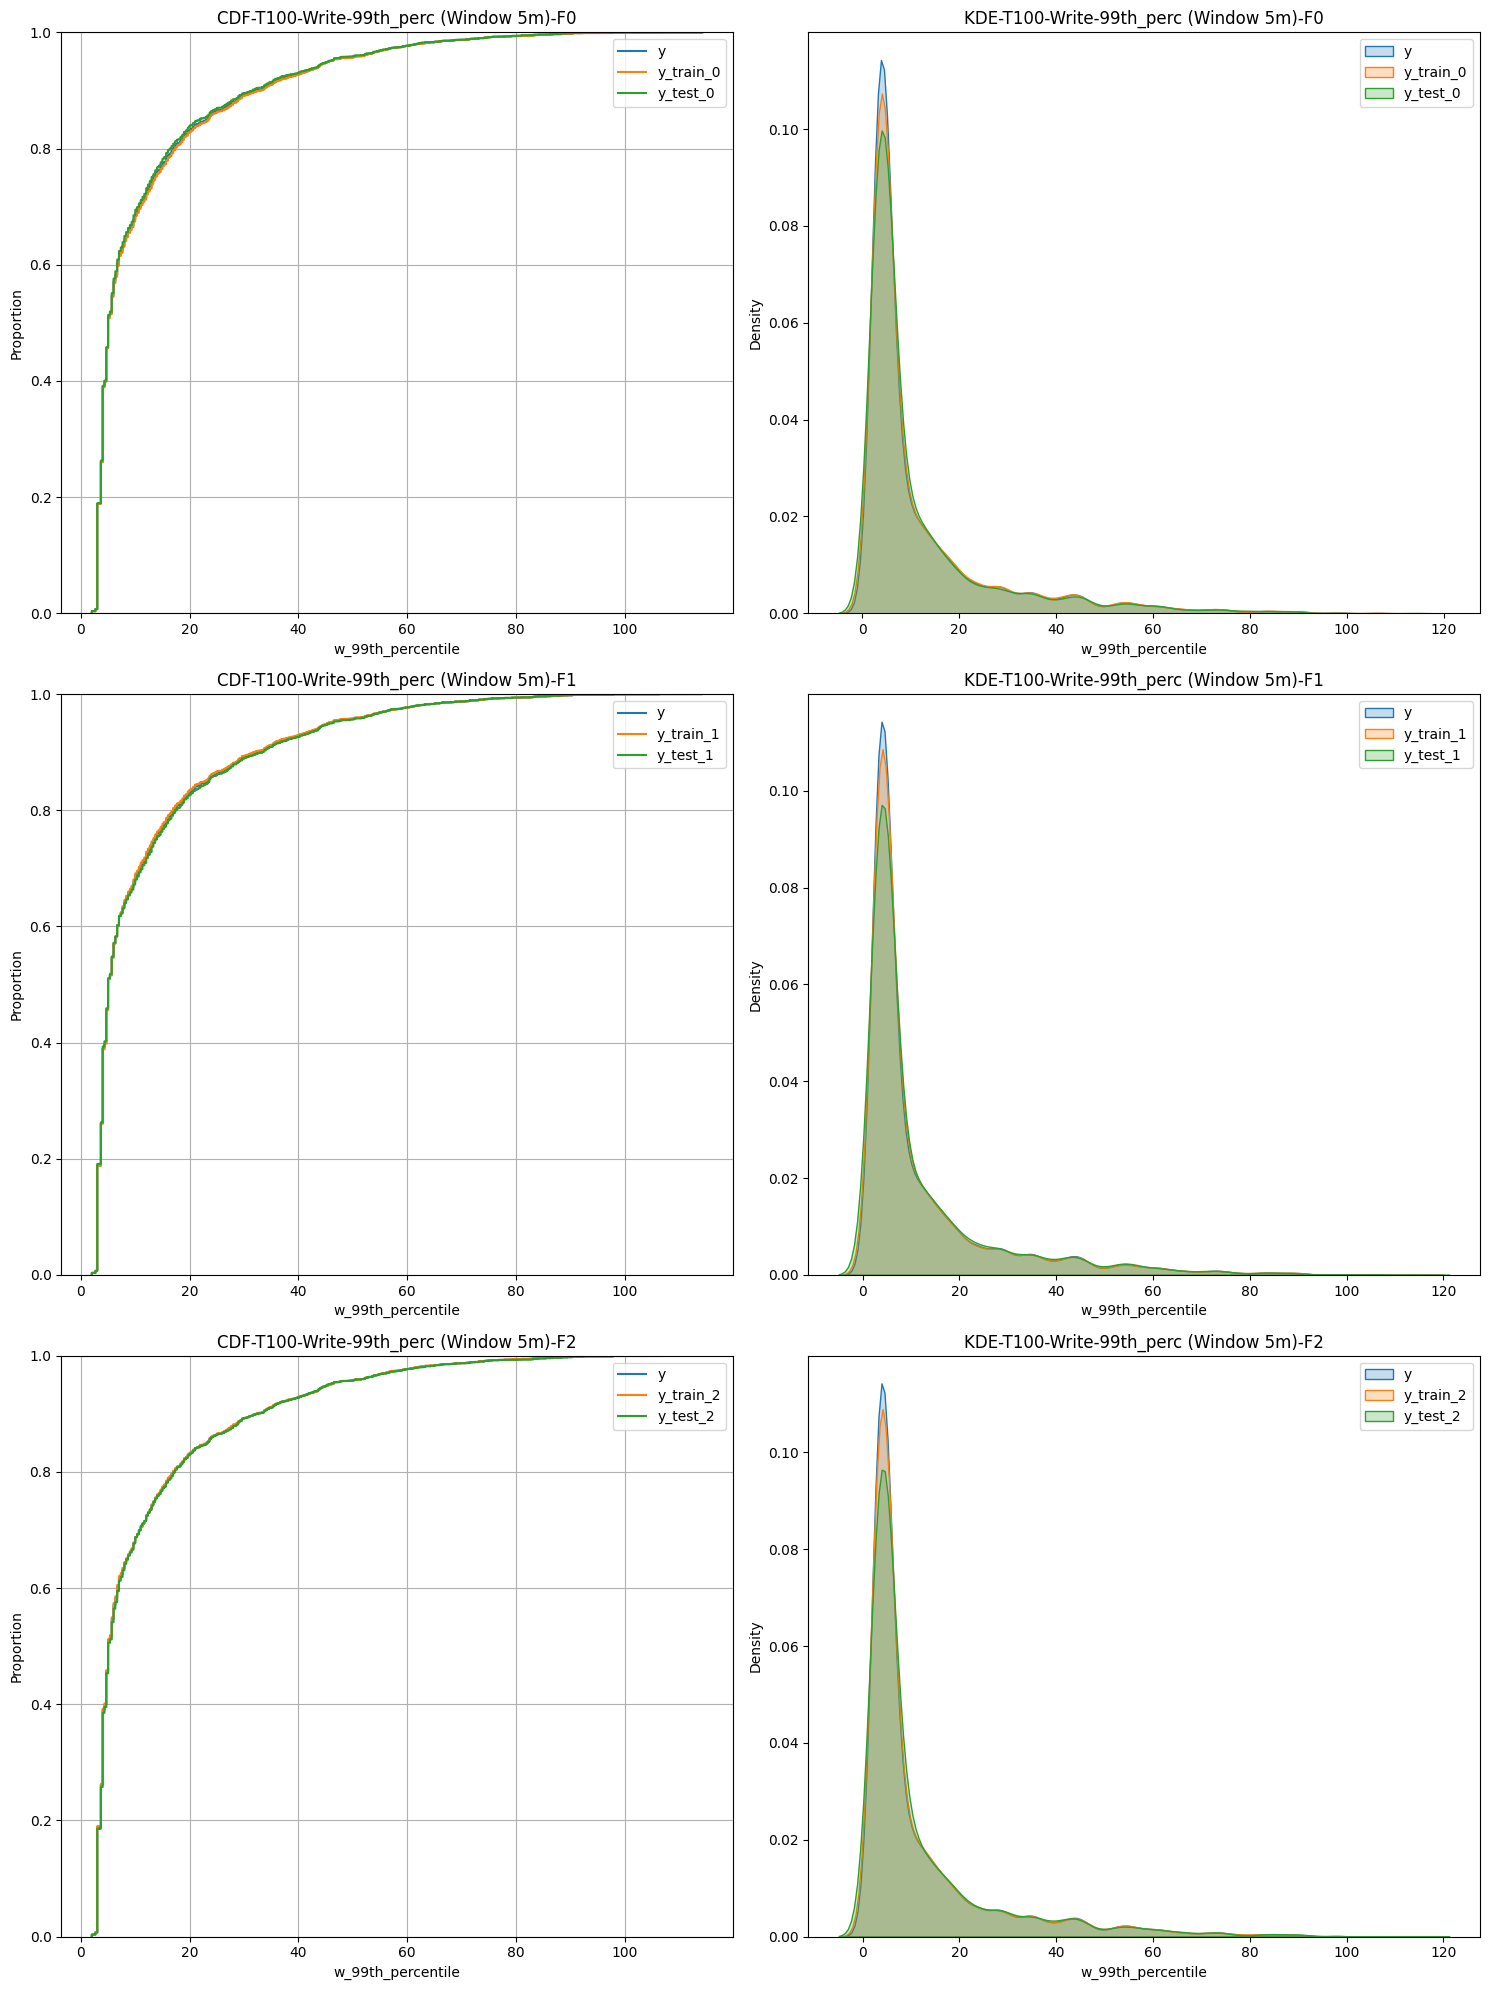

In [18]:

kfold_train_and_generate_plots(x_t100, y_t100, "w_99th_percentile", 3, "T100-Write-99th_perc (Window 5m)", "images/exp_90c_11h")

Min 2.0 | Max 114.296666666666
T100 - Rand. Forest Training time: 832.000665s
Fold 1: 20.93%
Fold 2: 21.31%
Fold 3: 21.80%
Mean NMAE: 21.35%



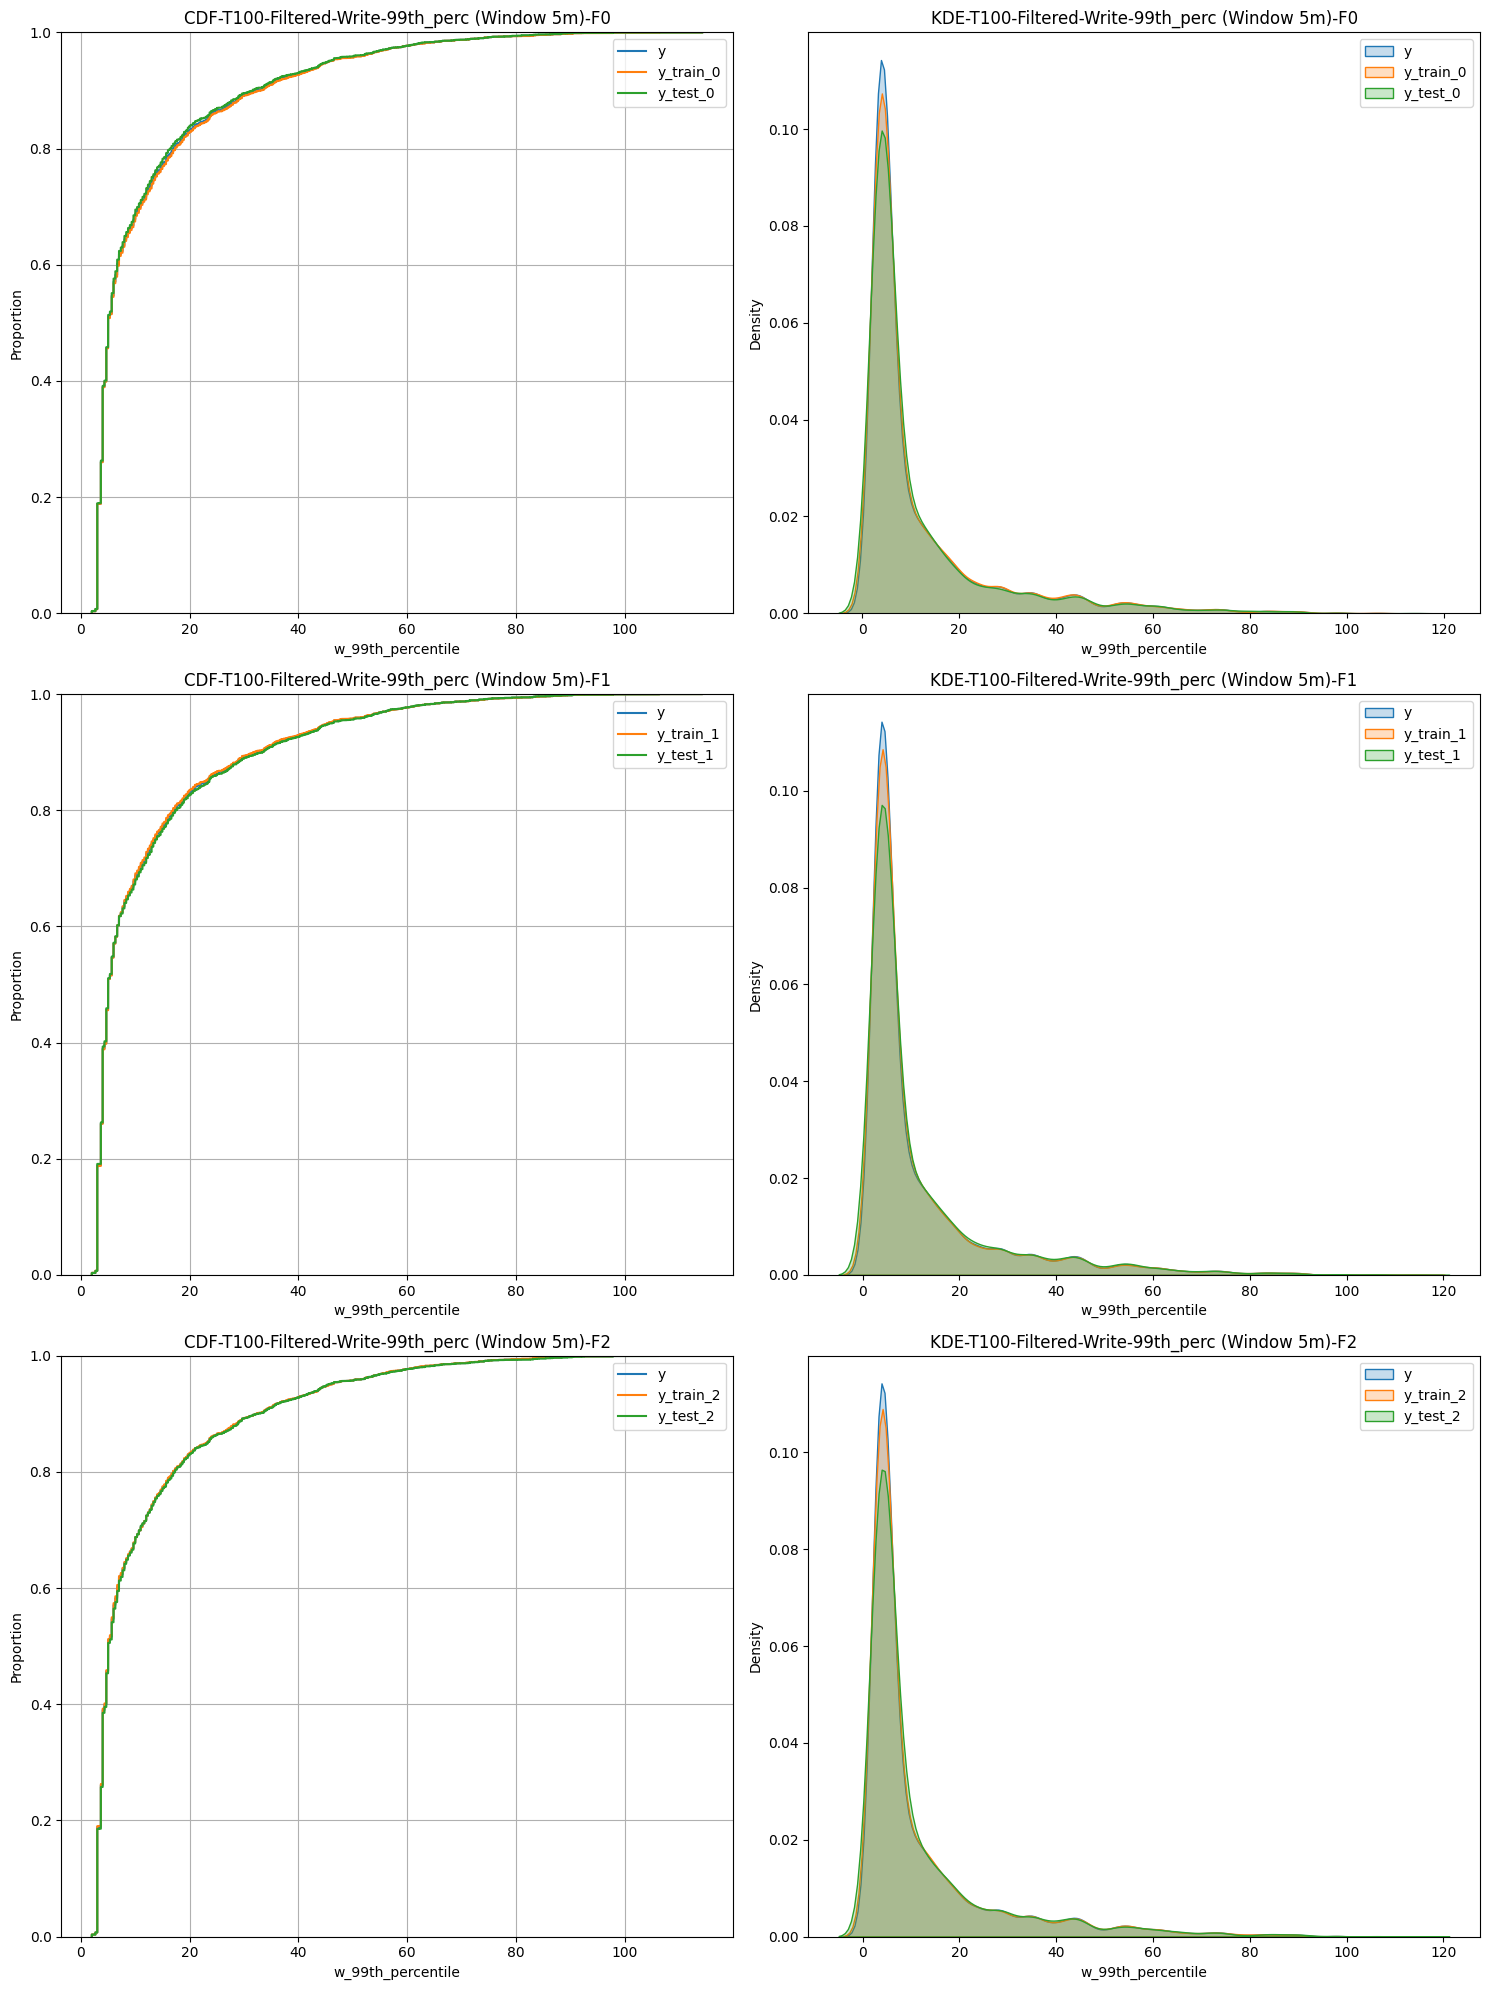

In [21]:
# using T100 w_99th_percentile
y_target = y_t100[["timestamp", "w_99th_percentile"]].copy()
df_merged = pd.merge(x_t100, y_target, on="timestamp", how="inner")

print(f"Min {df_merged["w_99th_percentile"].min()} | Max {df_merged[target_col].max()}")

# df_filtered = df_merged[df_merged["w_99th_percentile"] <= 20.0]
df_filtered = df_merged

y = df_filtered[["timestamp", "w_99th_percentile"]].copy()
X = df_filtered.drop(columns=["w_99th_percentile"])

kfold_train_and_generate_plots(X, y, "w_99th_percentile", 3, "T100-Filtered-Write-99th_perc (Window 5m)", "images/exp_90c_11h")

## T300

T100 - Rand. Forest Training time: 469.043954s
Fold 1: 0.04%
Fold 2: 0.05%
Fold 3: 0.04%
Mean NMAE: 0.04%



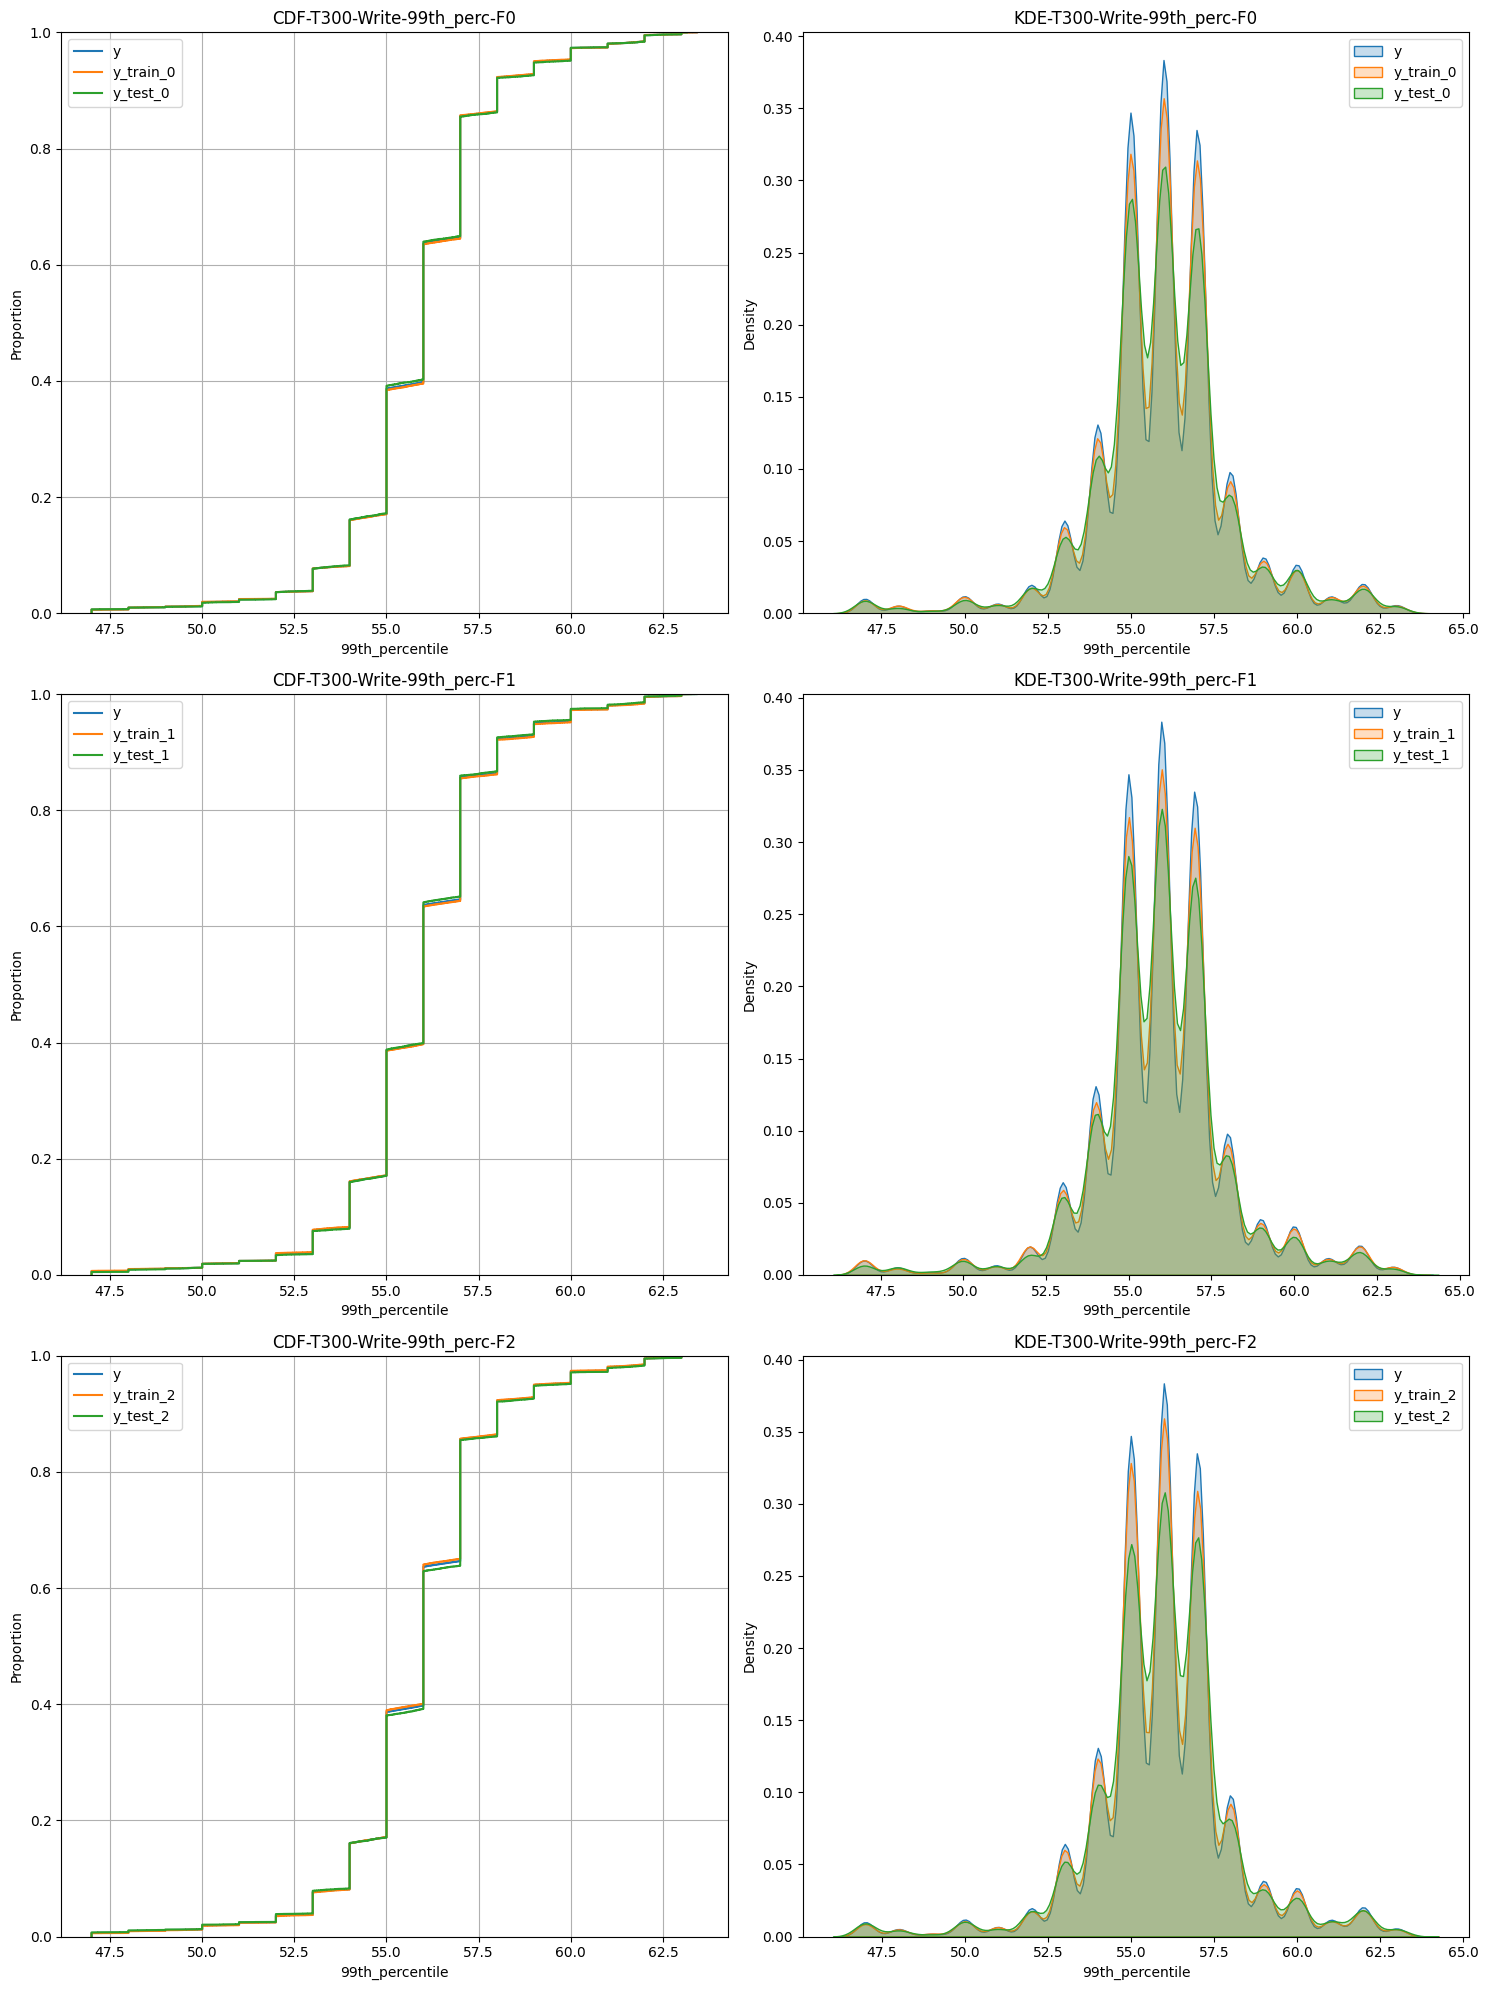

In [19]:
# Full dataset - wihout normalization...
kfold_train_and_generate_plots(x_t300, y_t300, "99th_percentile", 3, "T300-Write-99th_perc", "images/exp_90c_11h")

T100 - Rand. Forest Training time: 458.694101s
Fold 1: 2.74%
Fold 2: 2.71%
Fold 3: 2.77%
Mean NMAE: 2.74%



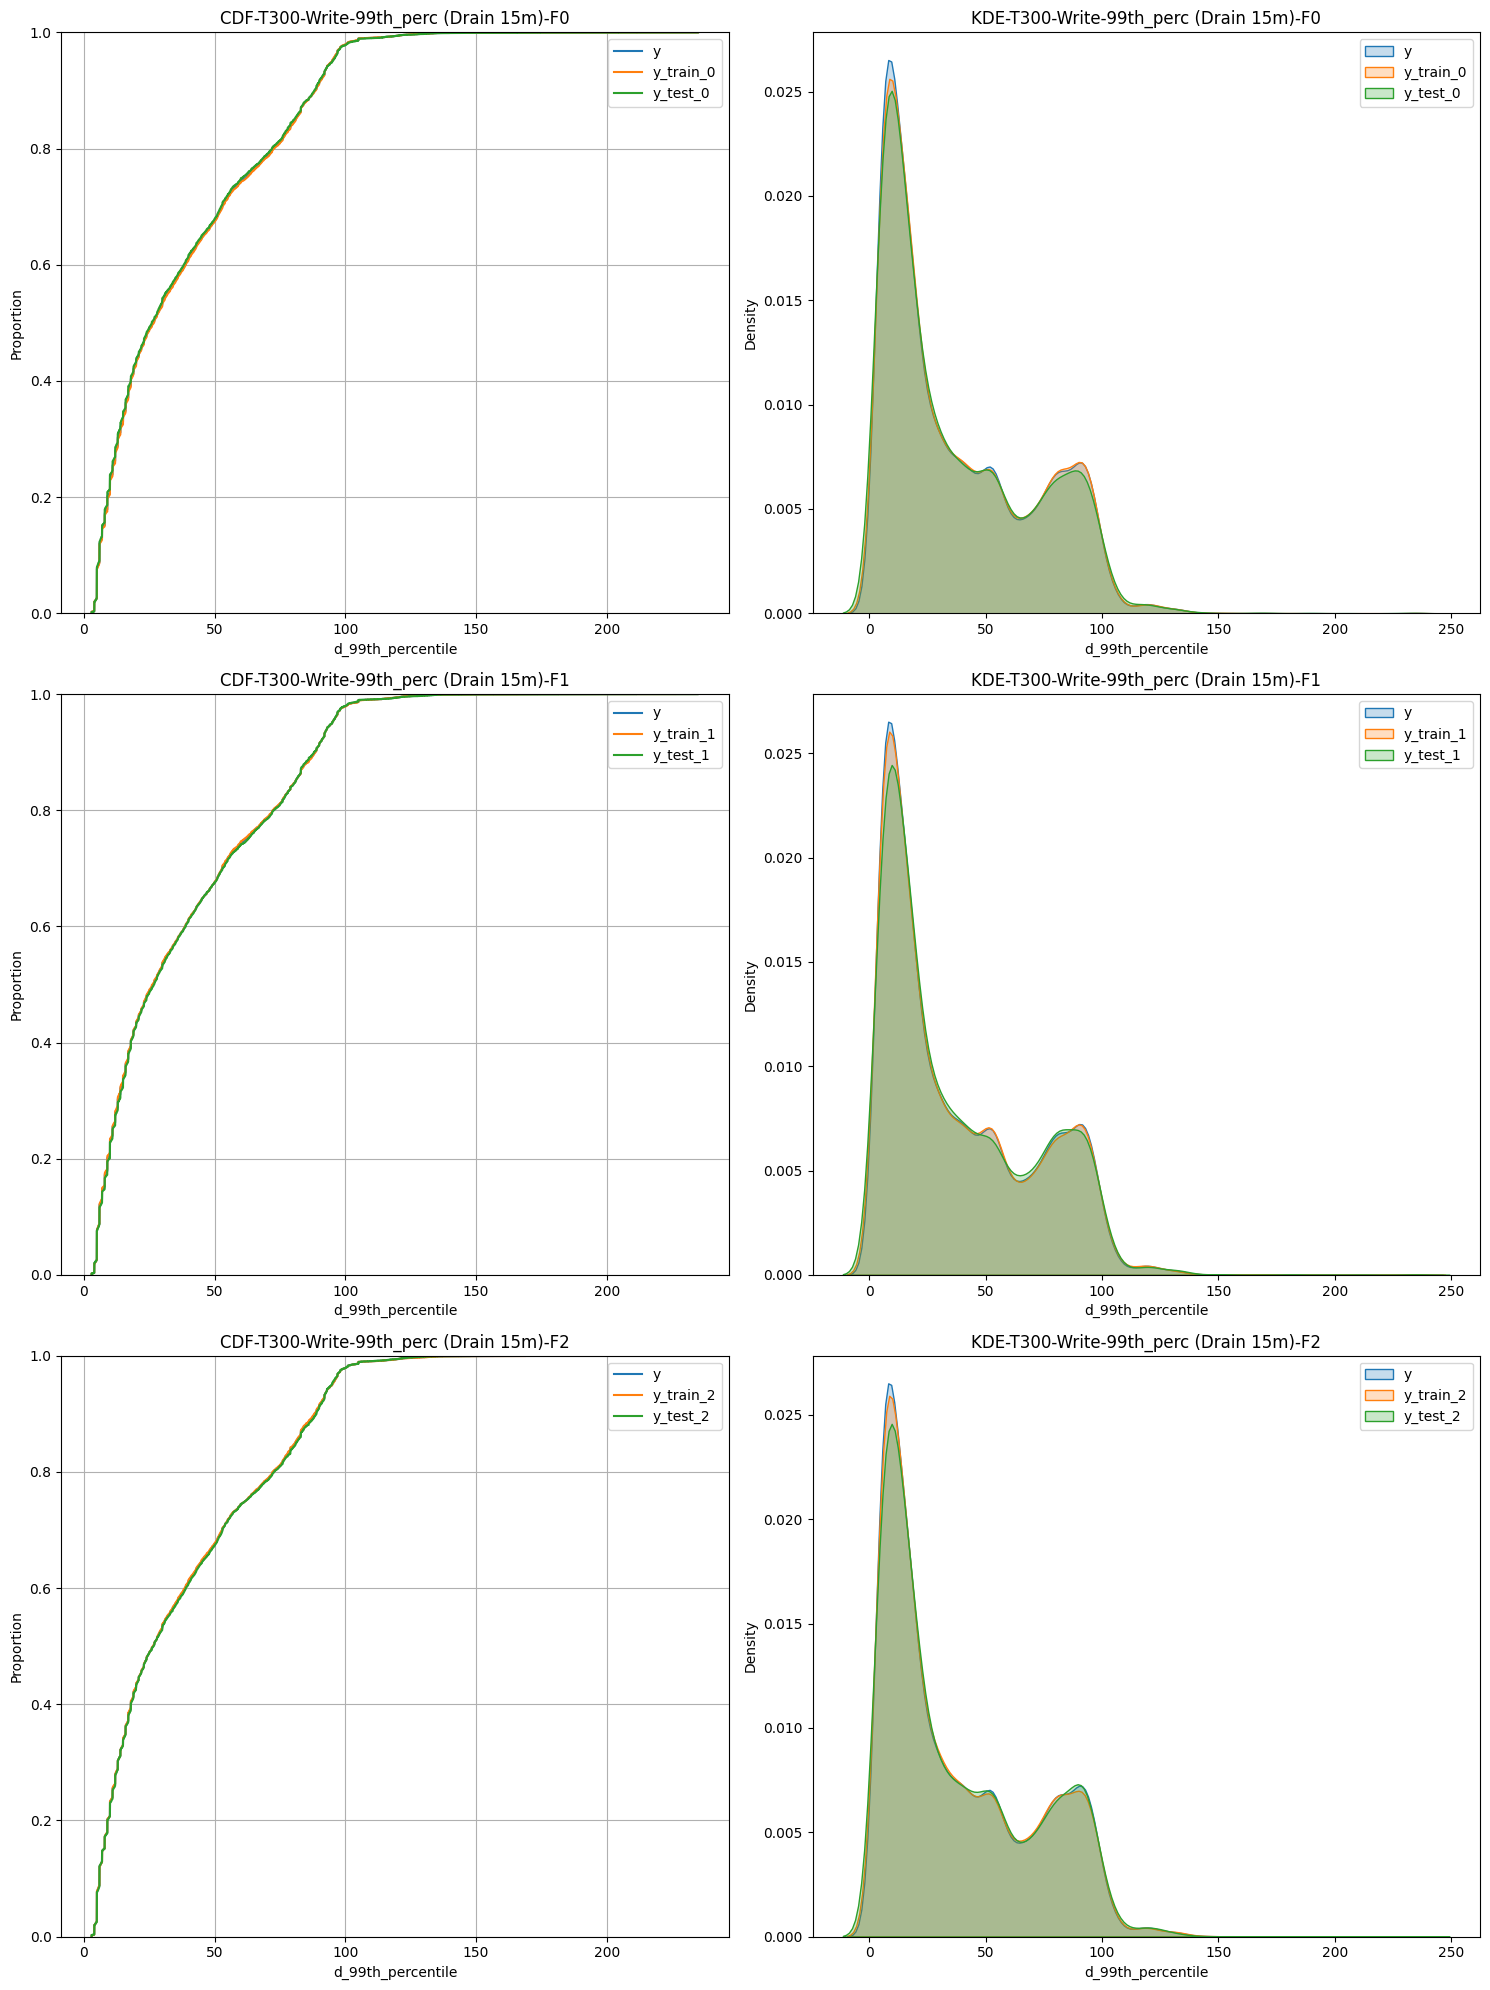

In [20]:
kfold_train_and_generate_plots(x_t300, y_t300, "d_99th_percentile", 3, "T300-Write-99th_perc (Drain 15m)", "images/exp_90c_11h")

T100 - Rand. Forest Training time: 482.022832s
Fold 1: 9.71%
Fold 2: 9.52%
Fold 3: 9.49%
Mean NMAE: 9.57%



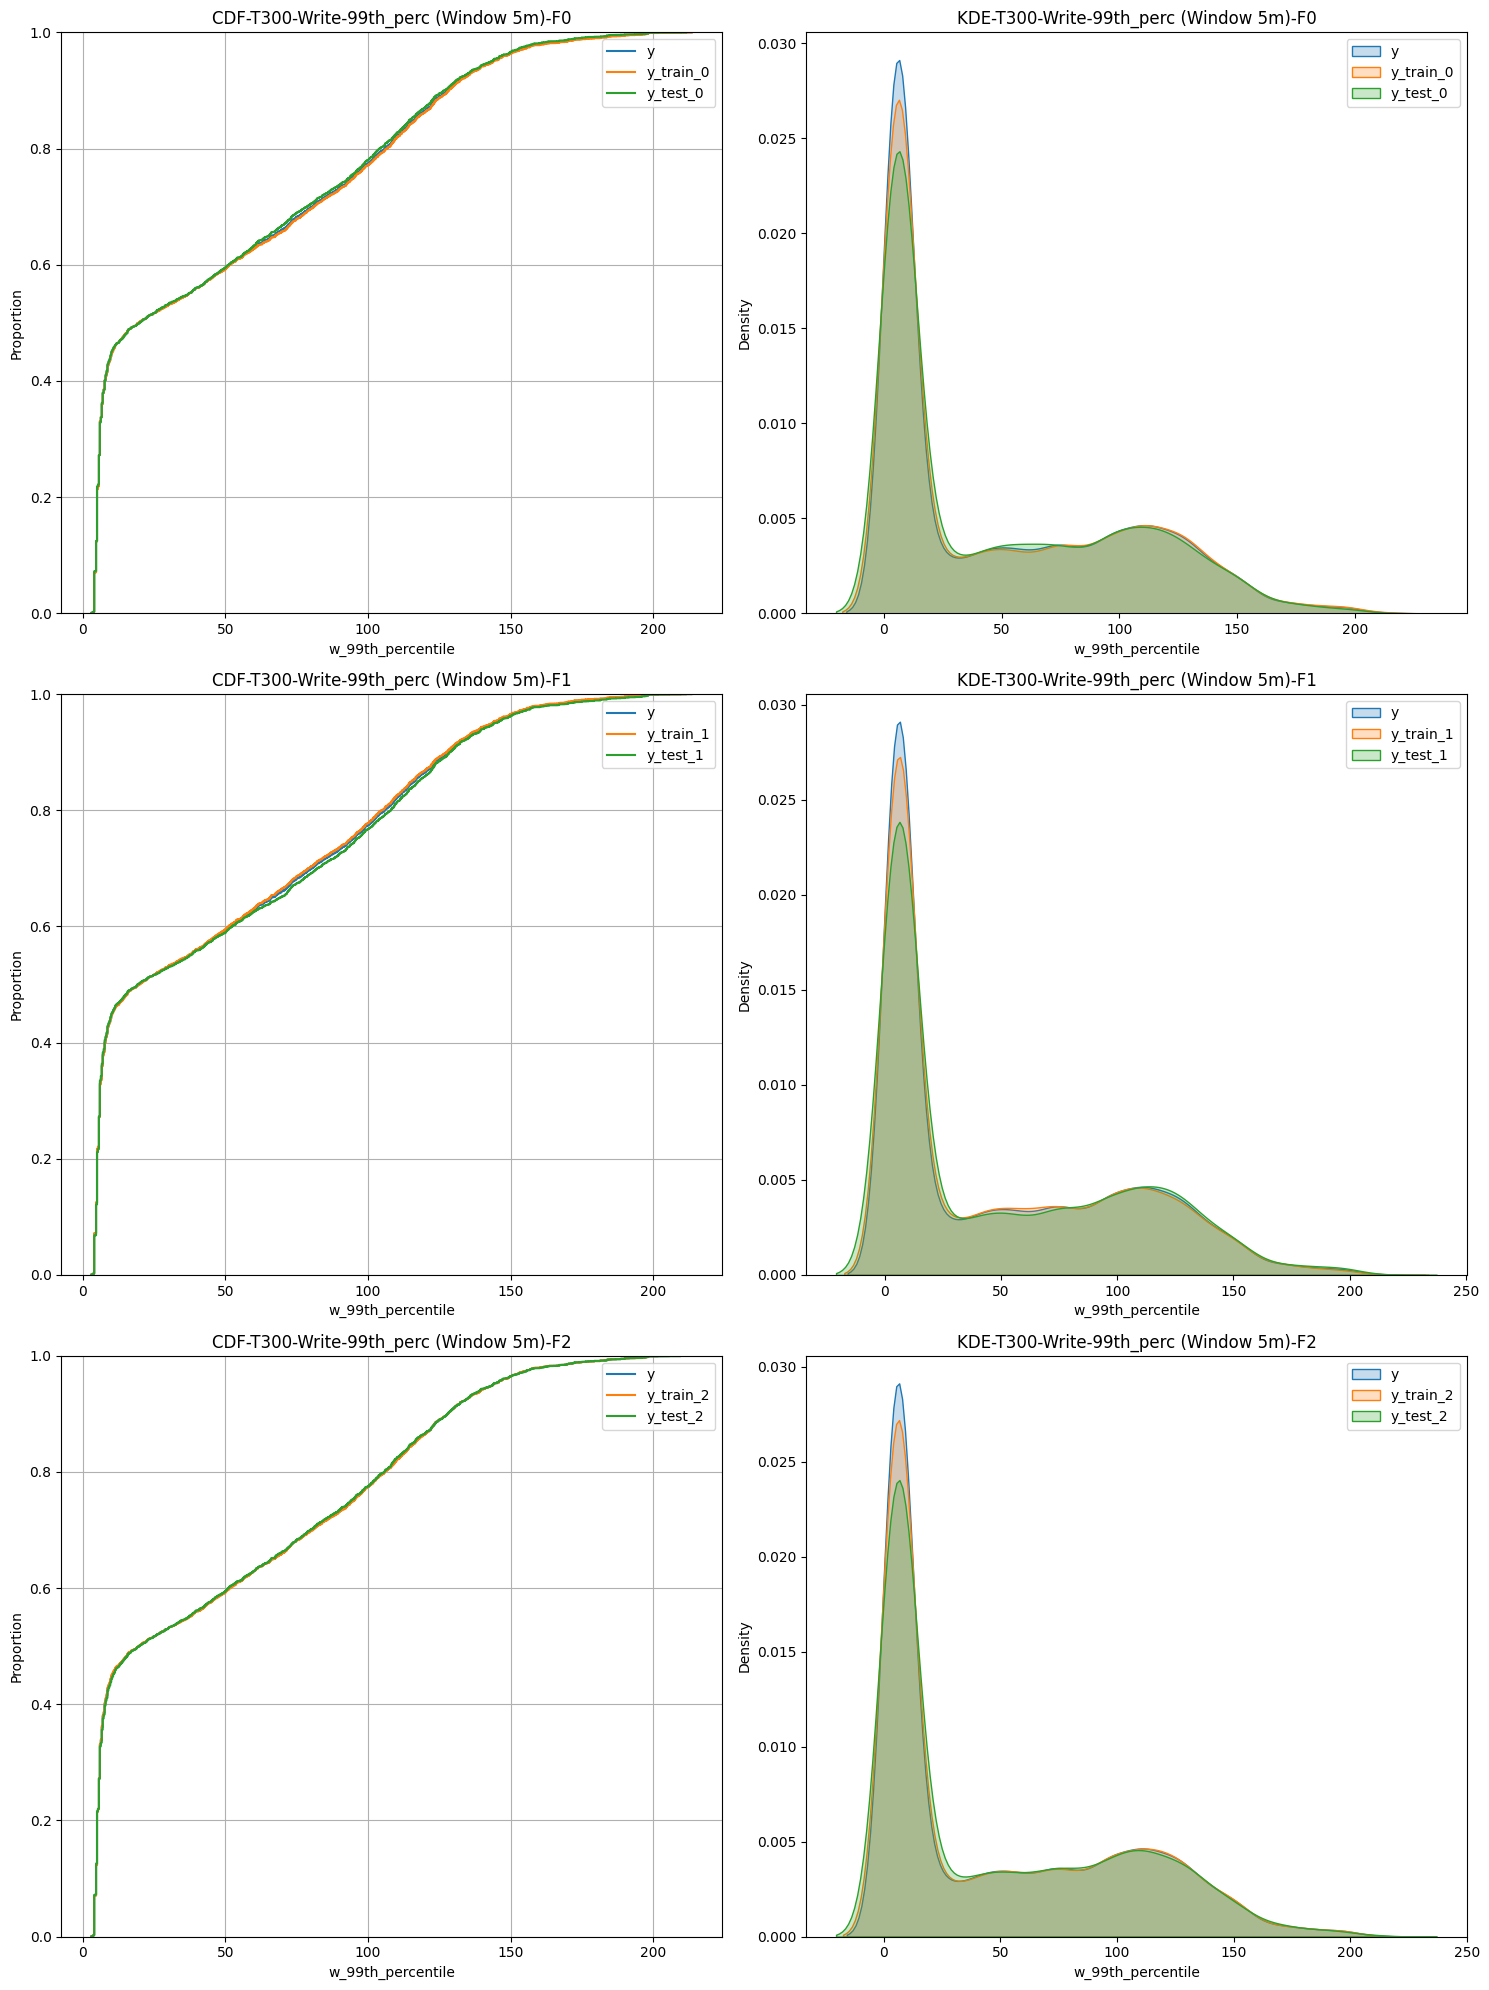

In [21]:
kfold_train_and_generate_plots(x_t300, y_t300, "w_99th_percentile", 3, "T300-Write-99th_perc (Window 5m)", "images/exp_90c_11h")

## T500

T100 - Rand. Forest Training time: 335.664146s
Fold 1: 0.02%
Fold 2: 0.02%
Fold 3: 0.02%
Mean NMAE: 0.02%



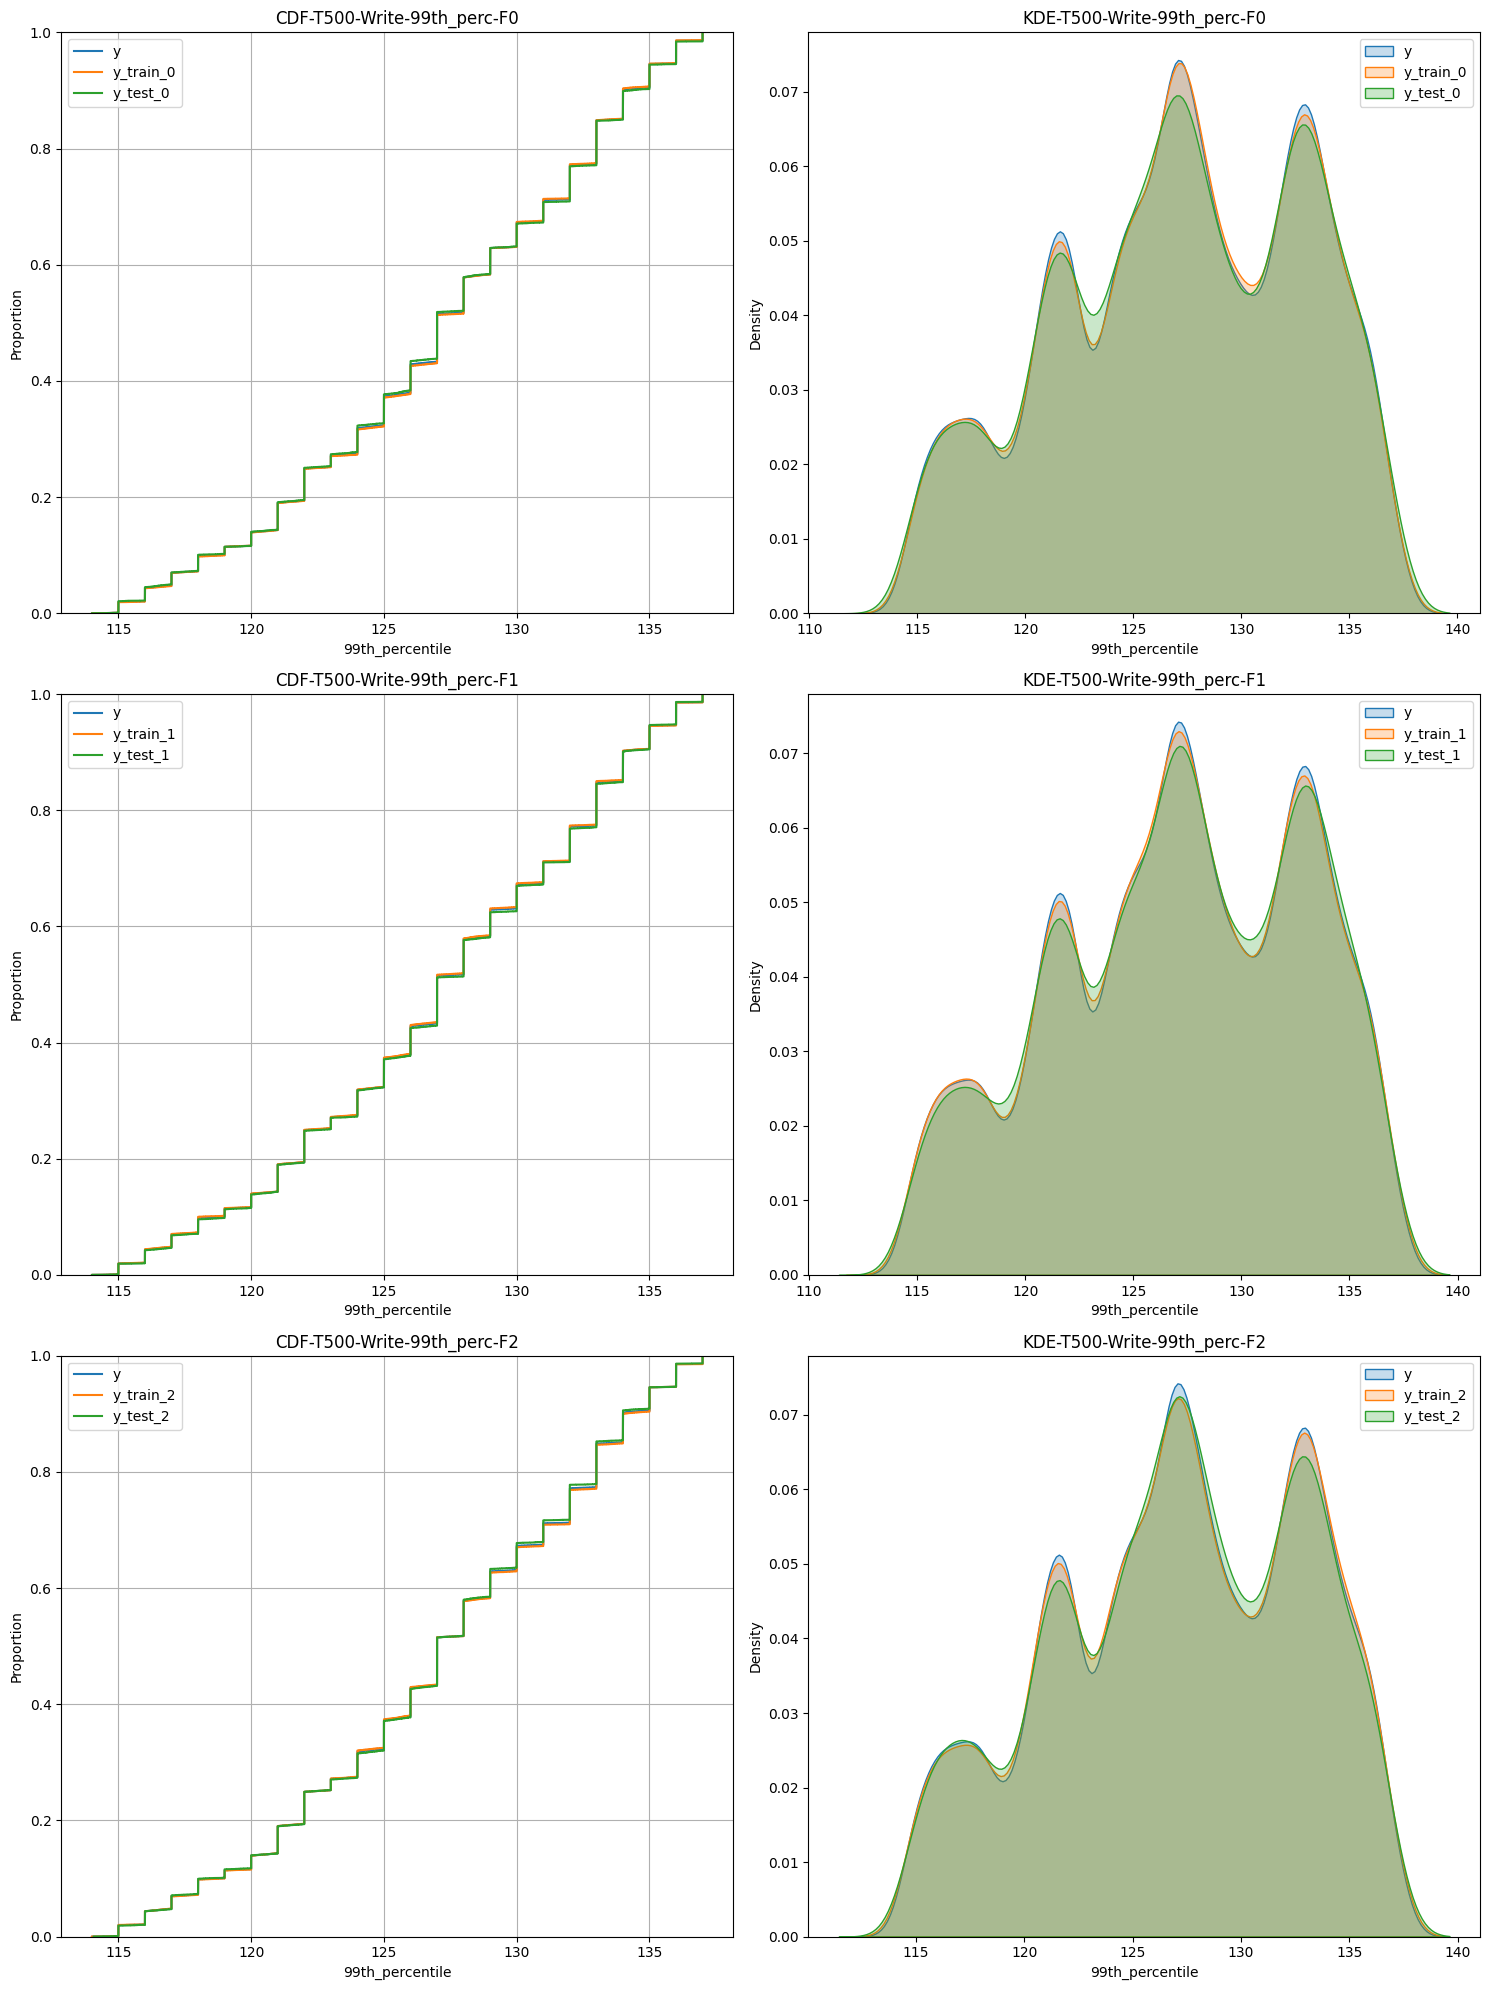

In [10]:
# Full dataset - wihout normalization...
kfold_train_and_generate_plots(x_t500, y_t500, "99th_percentile", 3, "T500-Write-99th_perc", "images/exp_90c_11h")

T100 - Rand. Forest Training time: 435.306465s
Fold 1: 1.83%
Fold 2: 1.85%
Fold 3: 1.81%
Mean NMAE: 1.83%



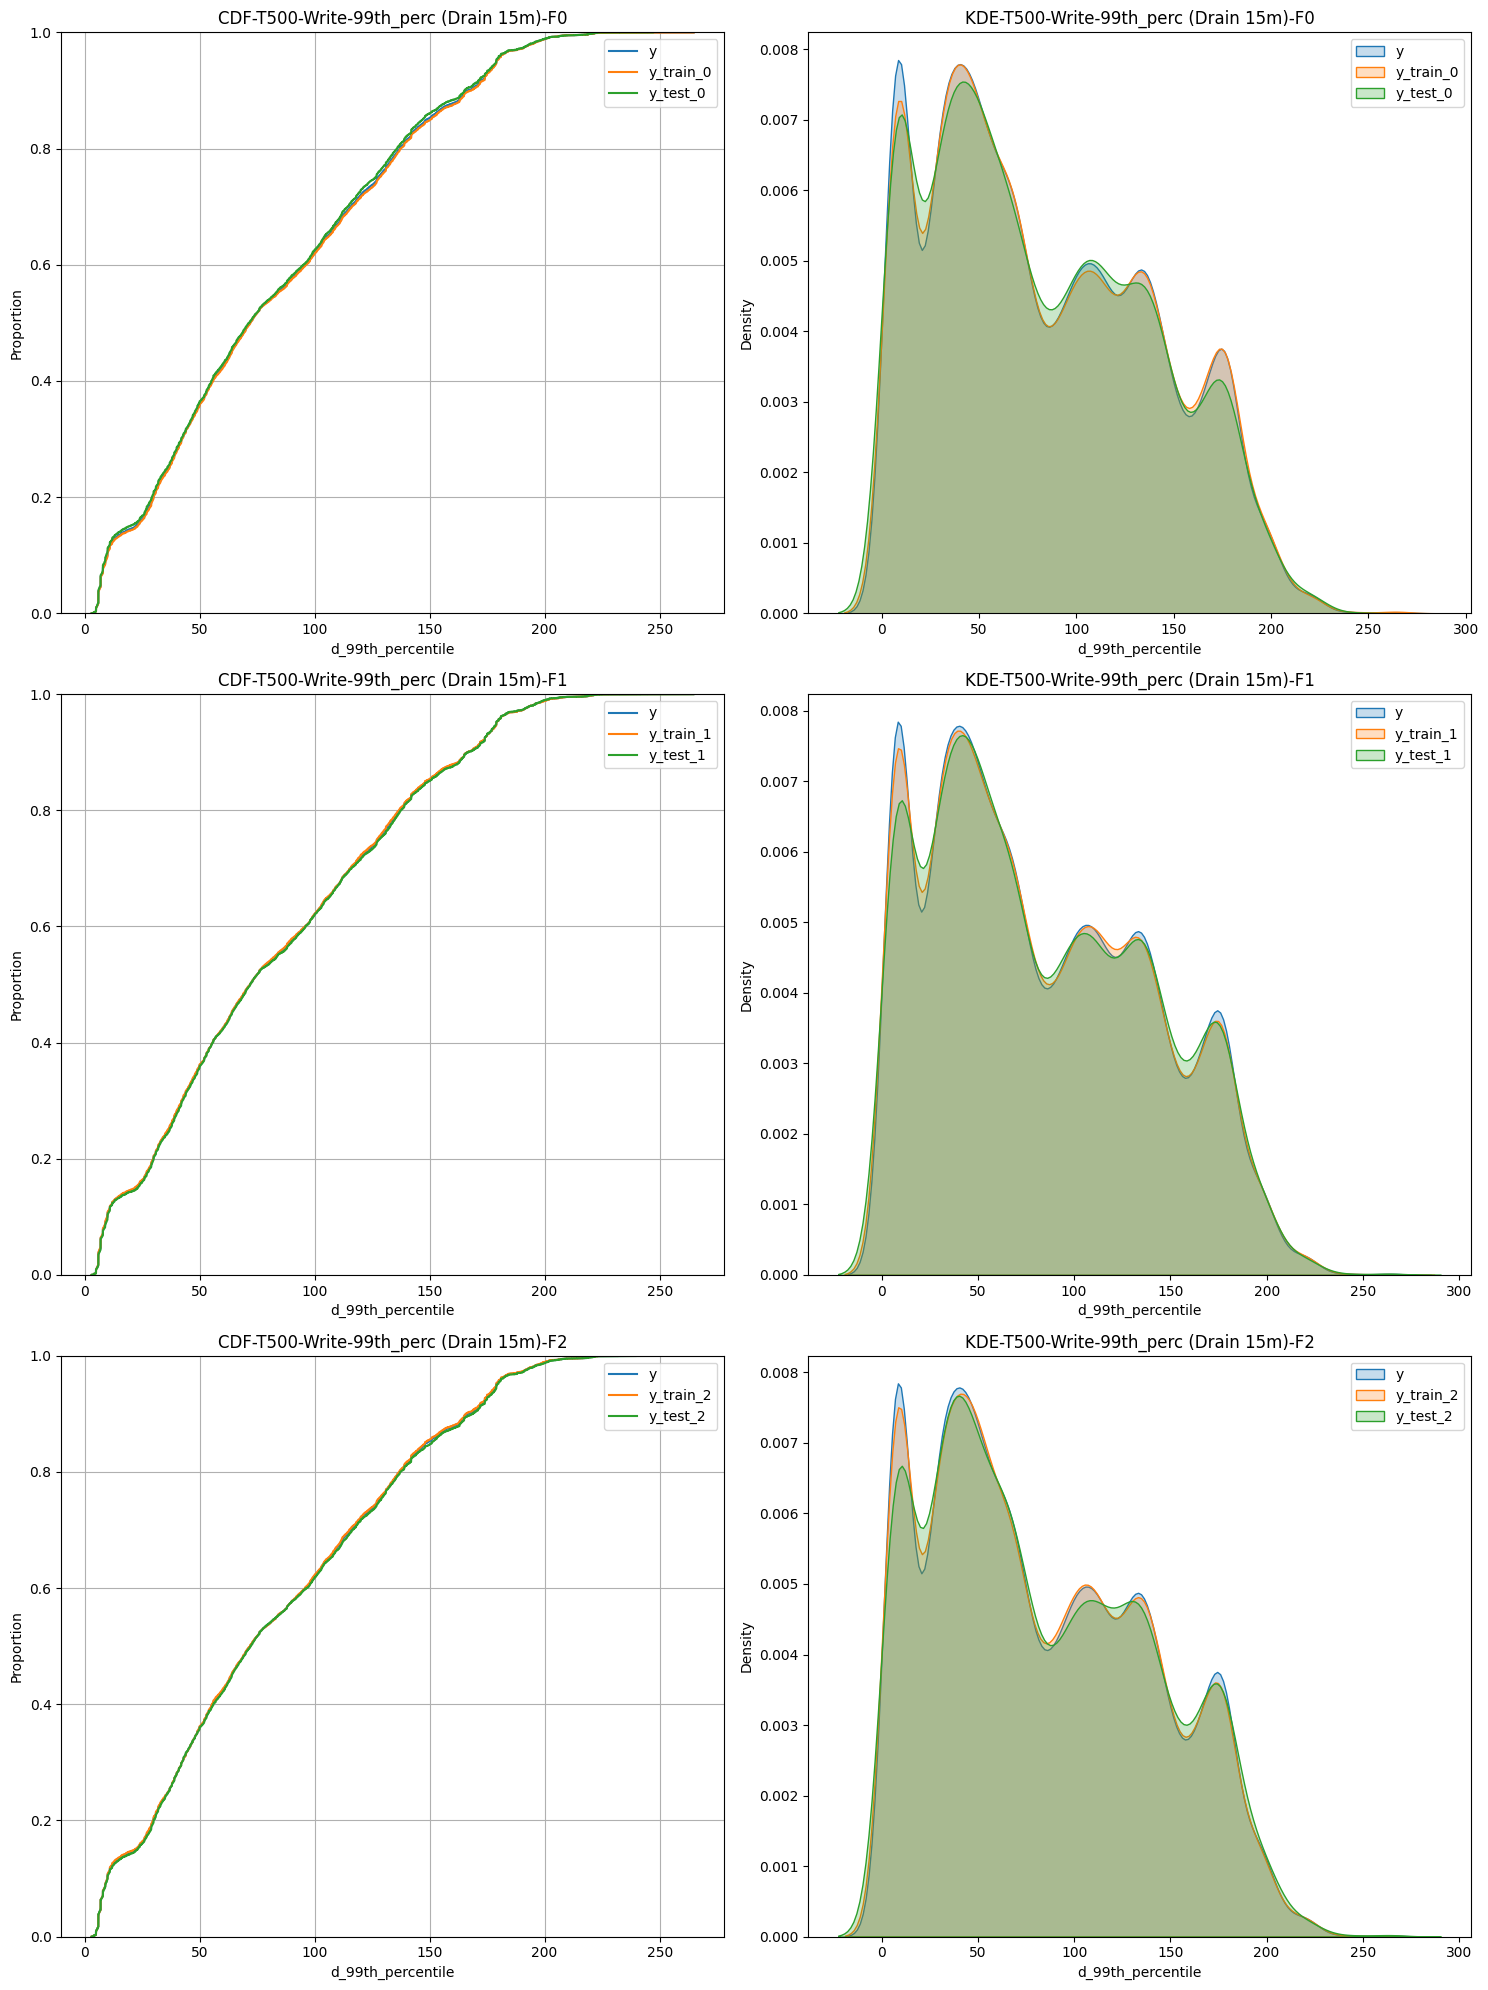

In [11]:
kfold_train_and_generate_plots(x_t500, y_t500, "d_99th_percentile", 3, "T500-Write-99th_perc (Drain 15m)", "images/exp_90c_11h")

T100 - Rand. Forest Training time: 496.898809s
Fold 1: 7.07%
Fold 2: 6.87%
Fold 3: 6.92%
Mean NMAE: 6.95%



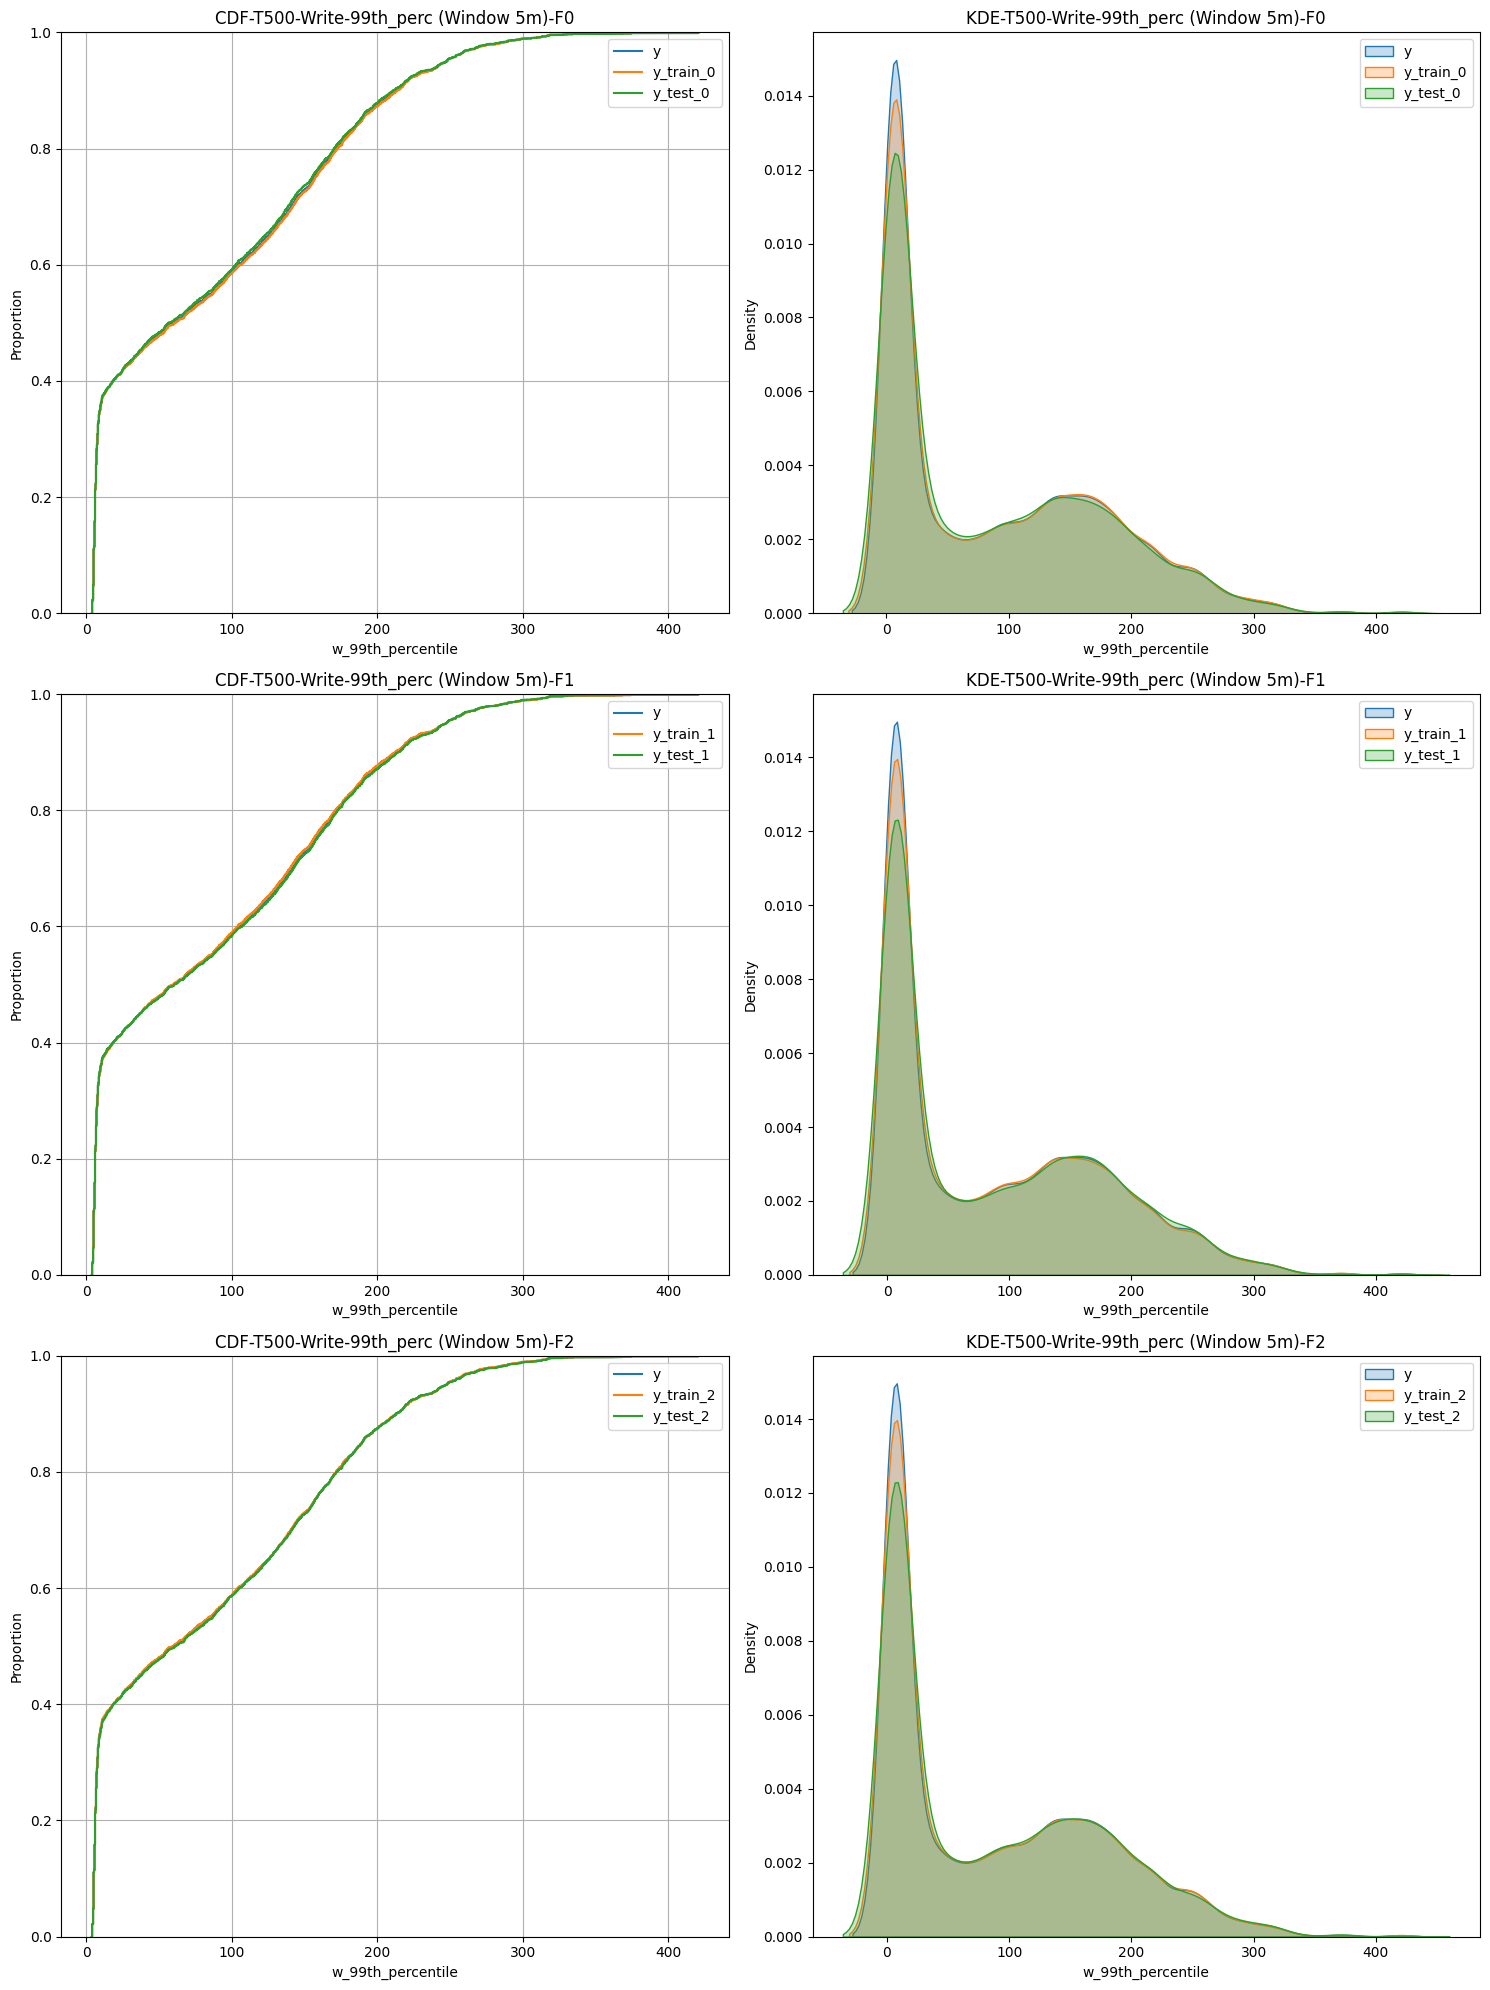

In [12]:
kfold_train_and_generate_plots(x_t500, y_t500, "w_99th_percentile", 3, "T500-Write-99th_perc (Window 5m)", "images/exp_90c_11h")

## Other models...

In [11]:
# Full dataset, using xgboost

# 3. Initialize the XGBoost Regressor model
# objective='reg:squarederror' is the default for regression, but explicitly setting it is good practice.
# n_estimators controls the number of boosting rounds (trees).
# random_state for reproducibility.
model = xgb.XGBRegressor(n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric=mean_absolute_error)

target_col = "w_99th_percentile"
# using T100 w_99th_percentile
y_target = y_t100[["timestamp", target_col]].copy()
df_merged = pd.merge(x_t100, y_target, on="timestamp", how="inner")

print(f"Min {df_merged[target_col].min()} | Max {df_merged[target_col].max()}")

df_filtered = df_merged[df_merged[target_col] <= 20.0]

y = df_filtered[[target_col]].copy()
X = df_filtered.drop(columns=[target_col])

x_train, x_test, y_train, y_test = train_test_split(X, y[target_col].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'XGBoost Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Min 2.0 | Max 114.296666666666
XGBoost Training time: 84.386186s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 12.94%


In [14]:
# 3. Initialize the XGBoost Regressor model
# objective='reg:squarederror' is the default for regression, but explicitly setting it is good practice.
# n_estimators controls the number of boosting rounds (trees).
# random_state for reproducibility.
model = xgb.XGBRegressor(n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric=mean_absolute_error)

# using T300 w_99th_percentile
y_target = y_t300[["timestamp", target_col]].copy()
df_merged = pd.merge(x_t300, y_target, on="timestamp", how="inner")

print(f"Min {df_merged[target_col].min()} | Max {df_merged[target_col].max()}")

df_filtered = df_merged

y = df_filtered[[target_col]].copy()
X = df_filtered.drop(columns=[target_col])

x_train, x_test, y_train, y_test = train_test_split(X, y[target_col].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'XGBoost Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Min 3.0 | Max 213.643333333333
XGBoost Training time: 87.436976s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 12.17%


In [15]:
# 3. Initialize the XGBoost Regressor model
# objective='reg:squarederror' is the default for regression, but explicitly setting it is good practice.
# n_estimators controls the number of boosting rounds (trees).
# random_state for reproducibility.
model = xgb.XGBRegressor(n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric=mean_absolute_error)

# using T500 w_99th_percentile
y_target = y_t500[["timestamp", target_col]].copy()
df_merged = pd.merge(x_t500, y_target, on="timestamp", how="inner")

print(f"Min {df_merged[target_col].min()} | Max {df_merged[target_col].max()}")

df_filtered = df_merged

y = df_filtered[[target_col]].copy()
X = df_filtered.drop(columns=[target_col])

x_train, x_test, y_train, y_test = train_test_split(X, y[target_col].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'XGBoost Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Min 3.6633333333333 | Max 420.653333333333
XGBoost Training time: 95.77342s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 9.53%


# LightGBM

In [20]:
# using T100 w_99th_percentile
# target_col = "w_99th_percentile"

# y_target = y_t100[["timestamp", target_col]].copy()
# df_merged = pd.merge(x_t100, y_target, on="timestamp", how="inner")

# print(f"Min {df_merged[target_col].min()} | Max {df_merged[target_col].max()}")

# # df_filtered = df_merged
# df_filtered = df_merged[df_merged[target_col] <= 20.0]

# y = df_filtered[[target_col]].copy()
# X = df_filtered.drop(columns=[target_col])

# x_train, x_test, y_train, y_test = train_test_split(X, y[target_col].to_numpy(), test_size=0.30, random_state=42)

# # ----------------------------
# # 4. Create the LightGBM dataset
# # ----------------------------
# train_data = lgb.Dataset(x_train, label=y_train)
# valid_data = lgb.Dataset(x_test, label=y_test)

# # ----------------------------
# # 5. Define model parameters
# # ----------------------------
# params = {
#     "objective": "regression",
#     "metric": "mae",
#     "boosting_type": "gbdt",
#     "learning_rate": 0.03,
#     "num_leaves": 128,
#     "max_depth": -1,
#     "min_data_in_leaf": 50,
#     "feature_fraction": 0.8,
#     "bagging_fraction": 0.8,
#     "bagging_freq": 5,
#     "lambda_l1": 0.5,
#     "lambda_l2": 1.0,
#     "verbosity": -1,
#     "seed": 42
# }

# # ----------------------------
# # 6. Train model
# # ----------------------------
# model = lgb.train(
#     params,
#     train_data,
#     valid_sets=[train_data, valid_data],
#     num_boost_round=1000,
#     callbacks=[lgb.early_stopping(stopping_rounds=50)]
# )

# # ----------------------------
# # 7. Predict
# # ----------------------------
# pred = model.predict(x_test)

# ----------------------------
# 8. Evaluate (MAE)
# ----------------------------
# mae = mean_absolute_error(y_test, pred)
# print("MAE:", mae)
# print(f"NMAE: {nmae(pred, y_test):.2%}")

# Get feature importances and names
feature_importances = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

# Create a DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and get the top 100 features
top_100_features = importance_df.sort_values(by='Importance', ascending=False).head(100)

print("Top 100 Features by Importance:")
print(top_100_features['Feature'].tolist())


# Assuming 'model' is a trained LightGBM model
# lgb.plot_importance(model, importance_type='gain', max_num_features=100, figsize=(10, 6))
# plt.title("LightGBM Feature Importance (Gain)")
# plt.show()

Top 100 Features by Importance:
['network_receive_bytes_per_container_7', 'network_receive_bytes_per_container_4', 'network_transmit_bytes_per_container_7', 'container_memory_rss_0', 'container_memory_rss_1', 'network_transmit_bytes_per_container_6', 'network_receive_bytes_per_container_8', 'container_memory_working_set_bytes_4', 'network_receive_bytes_per_container_2', 'container_memory_cache_7', 'container_fs_read_seconds_total_13', 'container_memory_rss_5', 'container_memory_rss_19', 'container_memory_rss_4', 'container_memory_rss_3', 'network_receive_bytes_per_container_0', 'container_memory_rss_2', 'container_memory_mapped_file_2', 'container_memory_rss_7', 'container_memory_mapped_file_4', 'container_memory_working_set_bytes_3', 'container_memory_cache_4', 'container_memory_total_active_file_bytes_4', 'container_memory_mapped_file_0', 'container_memory_usage_bytes_3', 'container_memory_working_set_bytes_7', 'container_memory_working_set_bytes_1', 'container_memory_usage_bytes_5',

# KDE for read dataset metrics

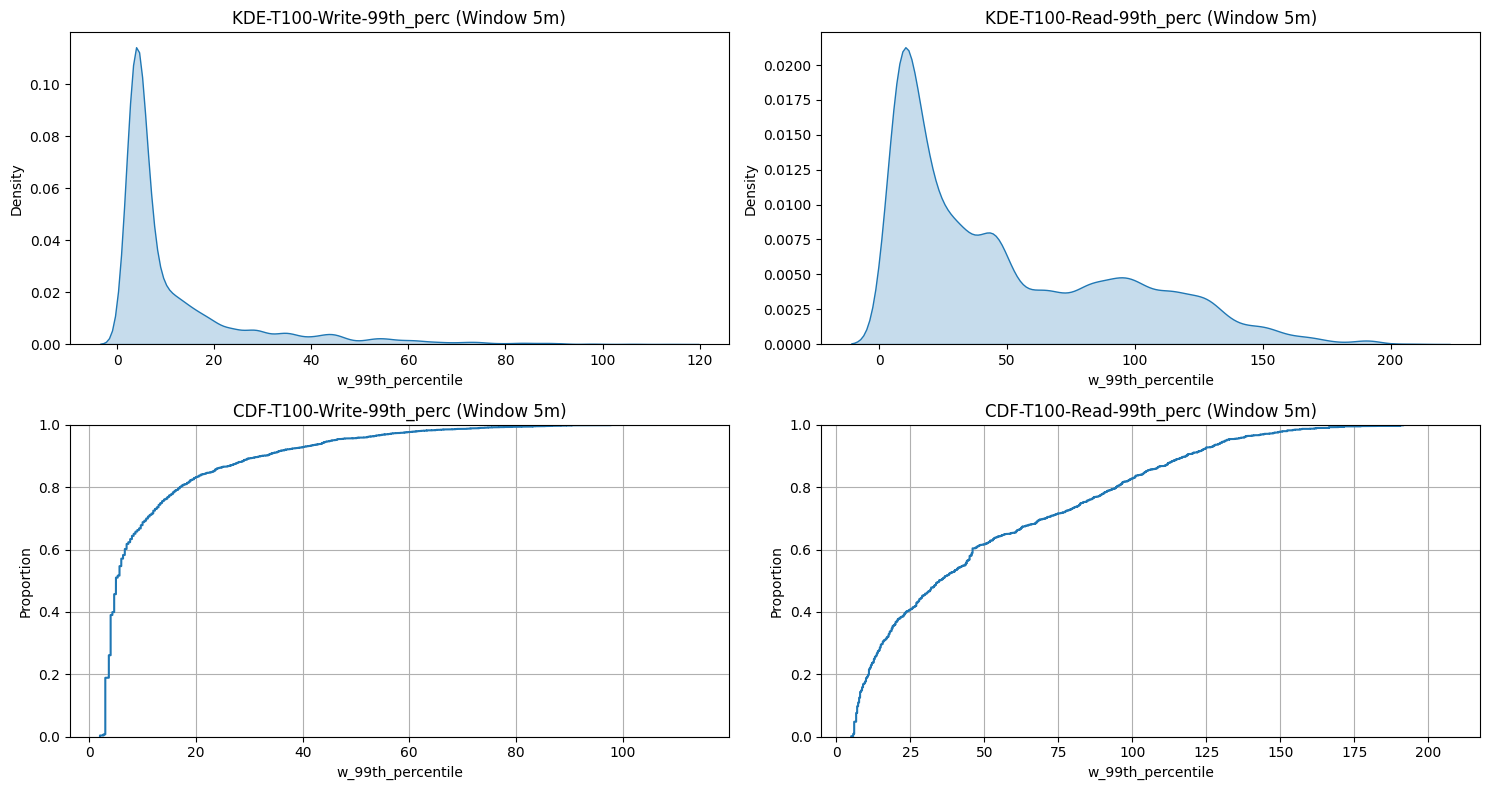

In [26]:
# 99th_percentile t100
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
sns.kdeplot(y_t100['w_99th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T100-Write-99th_perc (Window 5m)")

sns.kdeplot(y_t100_r['w_99th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T100-Read-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t100, x='w_99th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T100-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,0].grid(True)

sns.ecdfplot(data=y_t100_r, x='w_99th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T100-Read-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,1].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()